In [1]:
import os
import pathlib
from collections import ChainMap

import cv2
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from scipy.stats import chi2_contingency, entropy, false_discovery_control, mannwhitneyu
from shapely import Point, Polygon
from shapely.affinity import translate, scale
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import make_pipeline
from behavioral_analysis.moseq_tools.syllable_funcs import (compute_syllable_moseq_df, load_group_dict_from_csv, get_group_syllable_transition_series,
                                                            get_sampled_trajectory_df, get_normalized_trajectory_df,
                                                            trajectory_to_median_df, trajectory_median_full_index_check,
                                                            get_trajectory_median_distance_df)
from behavioral_analysis.pandas_tools.funcs import extract_neighbourhood_df, extract_series_neighbourhood_df
from behavioral_analysis.pandas_tools.old_code import series_to_value_chunks, value_chunks_to_series
from behavioral_analysis.pandas_tools.pattern_extraction import get_pattern_match_df, match_df_to_occurrence_df
from behavioral_analysis.pandas_tools.rle import rle_series
from behavioral_analysis.tracking_tools.funcs import aggregate_keypoint_df, extract_subtrack_df, normalize_track_df
from behavioral_analysis.tracking_tools.sleap_funcs import get_sleap_analysis_h5_skeleton_df
from behavioral_analysis.utility.builtin_classes.objects import save_object
from behavioral_analysis.utility.general import round_to_nearest_multiple
from behavioral_analysis.visualization.networkx_funcs import pair_dict_to_network_graph
from behavioral_analysis.visualization.shapely_funcs import bool_raster_to_polygon
from behavioral_analysis.visualization.video_funcs import get_first_frame
from tqdm.cli import tqdm

d:\BITrusted\conda_envs\manuscript2024\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = pathlib.Path(r"I:\2024_manuscript")

video_dir = root_dir / "videos"
data_output_dir = root_dir / "data_output"
tracking_dir = root_dir / "tracking"
moseq_project_dir = root_dir / "keypoint_moseq"

In [3]:
# calculate px_per_mm

edge_length = 453  #mm

vid_path = video_dir / list(video_dir.rglob("*.mp4"))[0]
first_frame = get_first_frame(vid_path)

roi = cv2.selectROI(first_frame)
cv2.destroyAllWindows()
roi_length = roi[2]
print(roi[3] / roi[2])
px_per_mm = roi_length/edge_length
px_per_mm

1.0076530612244898


0.8653421633554084

In [6]:
# global parameters
px_per_mm = 0.8653421633554084  # see above
contact_threshold = 100  # mm

minimum_syllable_onset_frequency = 0.005

fps = 25.23
start_frame_limit = int(fps * 30)  # 30 seconds
end_frame_limit = int(fps * 60 * 20)  # 20 minutes

bl6_light_cycle_date_dict = {
    "norm": pd.to_datetime("19-03-24"),
    "reverse": pd.to_datetime("20-03-24"),
}

In [7]:
tracking_df = pd.concat({track_file.name.rsplit(".", 1)[0]: pd.read_csv(track_file, index_col=0, header=[0, 1]) for track_file in tracking_dir.glob("*.csv")}, axis=0, names=["track"])
tracking_df

keypoint_name                                 instance  ear_left              \
keypoint_feature                                 score     score           x   
track                           frame_index                                    
1 - 21-02-24.analysis           0                  NaN       NaN         NaN   
                                1                  NaN       NaN         NaN   
                                2                  NaN       NaN         NaN   
                                3                  NaN       NaN         NaN   
                                4                  NaN       NaN         NaN   
...                                                ...       ...         ...   
7&10 - 20-03-24.analysis_track1 30400        10.101599  0.826593  157.444122   
                                30401        10.188427  0.856393  157.668869   
                                30402        10.249994  0.870006  157.535660   
                                30403        10.271636  0.885636  157.503357   
                                30404        10.241010  0.942254  157.371094   

keypoint_name                                           ear_right              \
keypoint_feature                                      y     score           x   
track                           frame_index                                     
1 - 21-02-24.analysis           0                   NaN       NaN         NaN   
                                1                   NaN       NaN         NaN   
                                2                   NaN       NaN         NaN   
                                3                   NaN       NaN         NaN   
                                4                   NaN       NaN         NaN   
...                                                 ...       ...         ...   
7&10 - 20-03-24.analysis_track1 30400        266.595428  0.805456  145.047165   
                                30401        266.841217  0.784494  145.022995   
                                30402        266.709656  0.788133  145.002335   
                                30403        266.645233  0.841853  144.693436   
                                30404        267.208191  0.865380  144.558777   

keypoint_name                                                head              \
keypoint_feature                                      y     score           x   
track                           frame_index                                     
1 - 21-02-24.analysis           0                   NaN       NaN         NaN   
                                1                   NaN       NaN         NaN   
                                2                   NaN       NaN         NaN   
                                3                   NaN       NaN         NaN   
                                4                   NaN       NaN         NaN   
...                                                 ...       ...         ...   
7&10 - 20-03-24.analysis_track1 30400        261.135529  0.818663  148.679672   
                                30401        261.532501  0.829741  148.740906   
                                30402        261.364471  0.827404  148.668701   
                                30403        260.925995  0.832420  148.429428   
                                30404        261.084534  0.837971  147.982254   

keypoint_name                                            ... spine_thoratic  \
keypoint_feature                                      y  ...              y   
track                           frame_index              ...                  
1 - 21-02-24.analysis           0                   NaN  ...            NaN   
                                1                   NaN  ...            NaN   
                                2                   NaN  ...            NaN   
                                3                   NaN  ...            NaN   
                                4                   NaN 

In [8]:
group_dict = load_group_dict_from_csv(moseq_project_dir / "index.csv")
name_group_df = pd.Series(group_dict).str.split(", ", expand=True)
name_group_df.columns = ["treatment", "context", "light_cycle", "shave_status"]

moseq_df = compute_syllable_moseq_df(str(moseq_project_dir / "results.h5"), group_dict=group_dict, smooth_centroids=True, smooth_heading=True)
moseq_df[["treatment", "context", "light_cycle", "shave_status"]] = moseq_df["group"].str.split(", ", expand=True)

# application of limits
moseq_df = moseq_df.loc[pd.IndexSlice[:, start_frame_limit:end_frame_limit], :]
moseq_df

centroid_x  centroid_y   heading  \
track                           frame_index                                     
1 - 21-02-24.analysis           756           78.633054  409.166669  2.442800   
                                757           78.633054  412.106139  2.204218   
                                758           78.052170  414.912978  2.185359   
                                759           77.818435  417.413945  2.136504   
                                760           77.706140  419.782589  2.105274   
...                                                 ...         ...       ...   
7&10 - 20-03-24.analysis_track1 30272        215.918055  212.280512  2.944130   
                                30273        208.603168  212.501689  2.954739   
                                30274        200.272810  213.195882  2.993109   
                                30275        192.997141  213.228413  2.993109   
                                30276        187.324546  214.799292  2.972206   

                                             syllable  \
track                           frame_index             
1 - 21-02-24.analysis           756                 1   
                                757                 1   
                                758                13   
                                759                13   
                                760                13   
...                                               ...   
7&10 - 20-03-24.analysis_track1 30272               5   
                                30273               5   
                                30274               5   
                                30275               5   
                                30276               5   

                                                                          group  \
track                           frame_index                                       
1 - 21-02-24.analysis           756                   Vehicle, Solitary, Normal   
                                757                   Vehicle, Solitary, Normal   
                                758                   Vehicle, Solitary, Normal   
                                759                   Vehicle, Solitary, Normal   
                                760                   Vehicle, Solitary, Normal   
...                                                                         ...   
7&10 - 20-03-24.analysis_track1 30272        Vehicle, Dyadic, Reverse, Unshaved   
                                30273        Vehicle, Dyadic, Reverse, Unshaved   
                                30274        Vehicle, Dyadic, Reverse, Unshaved   
                                30275        Vehicle, Dyadic, Reverse, Unshaved   
                                30276        Vehicle, Dyadic, Reverse, Unshaved   

                                             velocity_px_s  angular_velocity  \
track                           frame_index                                    
1 - 21-02-24.analysis           756              88.265142         -2.977538   
                                757             101.147777         -2.632186   
                                758              85.989485         -2.216982   
                                759              75.355969         -1.784897   
                                760              71.139130         -1.388754   
...                                                    ...               ...   
7&10 - 20-03-24.analysis_track1 30272           243.246585          0.112511   
                                30273           219.546911          0.145722   
                                30274           250.776992          0.159203   
                                30275           218.272241          0.158475   
                                30276           179.456493          0.152606   

                                             onset  syllable_frame  \
track                           frame_index               

In [9]:
save_object(moseq_df, data_output_dir / "moseq_df.pkl", overwrite=True)

In [10]:
syll_frequencies = moseq_df[moseq_df["onset"]]["syllable"].value_counts(normalize=True)
relevant_syllables = syll_frequencies[syll_frequencies.ge(minimum_syllable_onset_frequency)].sort_index().index
relevant_syllables

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype='int64', name='syllable')

In [11]:
onset_moseq_df = moseq_df.loc[moseq_df["onset"]]
onset_frame_proportions = onset_moseq_df.groupby(["context", "track"])["syllable"].value_counts(normalize=True).sort_index()

syll_pvalues = {}
for syll in relevant_syllables:
    syll_series = onset_frame_proportions.xs(syll, level="syllable")
    res = mannwhitneyu(syll_series.loc["Solitary"].values, syll_series.loc["Dyadic"].values)
    syll_pvalues[syll] = res.pvalue

syll_pvalue_series = pd.Series(syll_pvalues)
corr_syll_pvalue_series = pd.Series(false_discovery_control(syll_pvalue_series.values), index=syll_pvalue_series.index)
sig_syllables = corr_syll_pvalue_series[corr_syll_pvalue_series < 0.05].index
sig_syllables

Index([5, 7, 10, 12, 13, 18, 23, 30], dtype='int64')

# Figure 1

## Panel A

In [12]:
n_samples = 16
rng = np.random.default_rng(1231231)

In [13]:
name_dyadic_bool_series = moseq_df.index.get_level_values("track").unique().to_frame()["track"].str.contains("&")
dyadic_names = name_dyadic_bool_series[name_dyadic_bool_series].index

dyadic_moseq_df = moseq_df.loc[pd.IndexSlice[dyadic_names, :], :]

# reshape dyadic index to be the same as the contact series index
dyadic_moseq_df_reindexed = dyadic_moseq_df.copy().reset_index()
dyadic_moseq_df_reindexed["strain"] = "Bl6"
dyadic_moseq_df_reindexed["light_cycle"] = dyadic_moseq_df_reindexed["light_cycle"].replace({"Normal": "norm", "Reverse": "reverse"})
dyadic_moseq_df_reindexed["mouse_id_string"] = dyadic_moseq_df_reindexed["track"].str.extract(r"(\d+&\d+)")
dyadic_moseq_df_reindexed["track_id"] = dyadic_moseq_df_reindexed["track"].str.extract(r"_track(\d+)")
dyadic_moseq_df_reindexed = dyadic_moseq_df_reindexed.rename({"frame_idx": "frame_index"}, axis=1)
dyadic_moseq_df_reindexed = dyadic_moseq_df_reindexed.set_index(["strain", "light_cycle", "mouse_id_string", "track_id", "frame_index"])
dyadic_moseq_df_reindexed = dyadic_moseq_df_reindexed.sort_index()
dyadic_moseq_df_reindexed

track  \
strain light_cycle mouse_id_string track_id frame_index                                    
Bl6    norm        1&4             0        756           1&4 - 19-03-24.analysis_track0   
                                            757           1&4 - 19-03-24.analysis_track0   
                                            758           1&4 - 19-03-24.analysis_track0   
                                            759           1&4 - 19-03-24.analysis_track0   
                                            760           1&4 - 19-03-24.analysis_track0   
...                                                                                  ...   
       reverse     7&10            1        30272        7&10 - 20-03-24.analysis_track1   
                                            30273        7&10 - 20-03-24.analysis_track1   
                                            30274        7&10 - 20-03-24.analysis_track1   
                                            30275        7&10 - 20-03-24.analysis_track1   
                                            30276        7&10 - 20-03-24.analysis_track1   

                                                         centroid_x  \
strain light_cycle mouse_id_string track_id frame_index               
Bl6    norm        1&4             0        756          503.740443   
                                            757          503.479071   
                                            758          503.475448   
                                            759          503.445168   
                                            760          503.403356   
...                                                             ...   
       reverse     7&10            1        30272        215.918055   
                                            30273        208.603168   
                                            30274        200.272810   
                                            30275        192.997141   
                                            30276        187.324546   

                                                         centroid_y   heading  \
strain light_cycle mouse_id_string track_id frame_index                         
Bl6    norm        1&4             0        756          451.215687  0.938396   
                                            757          451.394892  0.996951   
                                            758          452.739480  1.017735   
                                            759          453.145234  1.084564   
                                            760          453.544596  1.084564   
...                                                             ...       ...   
       reverse     7&10            1        30272        212.280512  2.944130   
                                            30273        212.501689  2.954739   
                                            30274        213.195882  2.993109   
                                            30275        213.228413  2.993109   
                                            30276        214.799292  2.972206   

                                                         syllable  \
strain light_cycle mouse_id_string track_id frame_index             
Bl6    norm        1&4             0        756                17   
                                            757                17   
                                            758                17   
                                            759                17   
                                            760                17   
...                                                           ...   
       reverse     7&10            1        30272               5   
                                            30273               5   
                                            30274               5   
                                            30275               5   
                                            30276               5   

          

In [14]:
video_path_series = dyadic_moseq_df_reindexed.groupby(["strain", "light_cycle", "mouse_id_string", "track_id"]).apply(lambda x: x.iloc[0])["track"]
video_path_series = video_path_series.str.rsplit(".", n=1, expand=True)[0] + ".mp4"
video_path_series = video_path_series.apply(lambda x: str(video_dir / x)).rename("video_path")
video_path_series.index = video_path_series.index.to_frame().apply(tuple)

In [15]:
pre, post = 5, 15
minimum_length = 3
syll_series = moseq_df["syllable"]
syllable_rle = rle_series(syll_series)
syllable_rle = syllable_rle[syllable_rle["run_length"].ge(minimum_length)]

syll_subtrack_df = pd.concat({syll: extract_subtrack_df(tracking_df, syll_rle.index, span_before=pre, span_after=post) for syll, syll_rle in syllable_rle.groupby("run_value")}, names=["syllable"])
syll_subtrack_df

keypoint_name                                                       instance  \
keypoint_feature                                                       score   
syllable track                  reference_frame_index frame_index              
0        1 - 21-02-24.analysis  771                   -5            9.245811   
                                                      -4            9.201622   
                                                      -3           10.100864   
                                                      -2            9.948790   
                                                      -1           10.119018   
...                                                                      ...   
98       19 - 23-02-24.analysis 10674                  11           9.944209   
                                                       12           9.944894   
                                                       13          10.325887   
                                                       14           9.971050   
                                                       15          10.247054   

keypoint_name                                                      ear_left  \
keypoint_feature                                                      score   
syllable track                  reference_frame_index frame_index             
0        1 - 21-02-24.analysis  771                   -5           0.737335   
                                                      -4           0.764256   
                                                      -3           0.837056   
                                                      -2           0.815635   
                                                      -1           0.795958   
...                                                                     ...   
98       19 - 23-02-24.analysis 10674                  11          0.702669   
                                                       12          0.579293   
                                                       13          0.605679   
                                                       14          0.647329   
                                                       15          0.759863   

keypoint_name                                                                  \
keypoint_feature                                                            x   
syllable track                  reference_frame_index frame_index               
0        1 - 21-02-24.analysis  771                   -5            75.594307   
                                                      -4            75.533882   
                                                      -3            77.620491   
                                                      -2            79.598633   
                                                      -1            81.179558   
...                                                                       ...   
98       19 - 23-02-24.analysis 10674                  11          154.542755   
                                                       12          145.206512   
                                                       13          138.463959   
                                                       14          134.143021   
                                                       15          132.241028   

keypoint_name                                                                  \
keypoint_feature                                                            y   
syllable track                  reference_frame_index frame_index               
0        1 - 21-02-24.analysis  771                   -5           439.601349   
                                                      -4           438.757355   
                                                      -3           435.637238   
                                                      -2           433.113098   
                                                      -1           431

In [16]:
pca_samples=50000
pca_dim=4
n_neighbors=50
coordinates=syll_subtrack_df
num_samples=50
pre=5
post=15

rng = np.random.default_rng(1231231)

X = syll_subtrack_df.copy().unstack("frame_index")
if X.shape[0] > pca_samples:
    X = X.sample(n=pca_samples, random_state=rng)

X = X.drop("instance", axis=1, level=0).drop("score", axis=1, level=1)
X = X.interpolate(method="linear", axis=0, limit_direction="both")

pca = PCA(n_components=pca_dim).fit(X)
X_pca = pca.transform(X)
all_nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X_pca)

sampled_instances = {}

for syllable, syllable_instances in syll_subtrack_df.groupby("syllable"):
    if syllable not in relevant_syllables:
        continue

    syllable_instances = syllable_instances.unstack("frame_index")
    X = syllable_instances.copy()
    X = X.drop("instance", axis=1, level=0).drop("score", axis=1, level=1)
    X = X.interpolate(method="linear", axis=0, limit_direction="both")

    X_pca = pca.transform(X)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X_pca)
    distances, indices = nbrs.kneighbors(X_pca)
    local_density = 1 / distances.mean(1)

    distances, _ = all_nbrs.kneighbors(X_pca)
    global_density = 1 / distances.mean(1)
    exemplar = np.argmax(local_density / global_density)
    samples = rng.choice(indices[exemplar], num_samples, replace=False)
    sampled_instances[syllable] = syllable_instances.iloc[samples]
sampled_instances_trajectories = pd.concat(sampled_instances.values(), axis=0).stack("frame_index", future_stack=True)
sampled_instances_trajectories

keypoint_name                                                       instance  \
keypoint_feature                                                       score   
syllable track                  reference_frame_index frame_index              
0        7 - 23-02-24.analysis  3676                  -5            8.939022   
                                                      -4            8.838750   
                                                      -3            9.441926   
                                                      -2            9.963372   
                                                      -1            9.789289   
...                                                                      ...   
31       16 - 23-02-24.analysis 19745                  11          10.501702   
                                                       12          10.375097   
                                                       13          10.053294   
                                                       14           9.650311   
                                                       15          10.106670   

keypoint_name                                                      ear_left  \
keypoint_feature                                                      score   
syllable track                  reference_frame_index frame_index             
0        7 - 23-02-24.analysis  3676                  -5           0.772350   
                                                      -4           0.873766   
                                                      -3           0.898108   
                                                      -2           0.859685   
                                                      -1           0.943276   
...                                                                     ...   
31       16 - 23-02-24.analysis 19745                  11          0.676915   
                                                       12          0.782178   
                                                       13          0.704341   
                                                       14          0.728872   
                                                       15          0.818870   

keypoint_name                                                                  \
keypoint_feature                                                            x   
syllable track                  reference_frame_index frame_index               
0        7 - 23-02-24.analysis  3676                  -5            68.554321   
                                                      -4            69.337448   
                                                      -3            71.110123   
                                                      -2            71.971169   
                                                      -1            75.364601   
...                                                                       ...   
31       16 - 23-02-24.analysis 19745                  11          216.959213   
                                                       12          217.872421   
                                                       13          220.167313   
                                                       14          222.455948   
                                                       15          225.877975   

keypoint_name                                                                  \
keypoint_feature                                                            y   
syllable track                  reference_frame_index frame_index               
0        7 - 23-02-24.analysis  3676                  -5           454.078003   
                                                      -4           451.444214   
                                                      -3           447.113770   
                                                      -2           444.364685   
                                                      -1           442

In [17]:
corresponding_moseq_df = moseq_df.rename({"centroid_x": "x", "centroid_y": "y"}, axis=1)

syll_corresponding_moseq_df = {}
for syll, syll_rle in syllable_rle.groupby("run_value"):
    syll_corresponding_moseq_df[syll] = extract_subtrack_df(corresponding_moseq_df, syll_rle.index, span_before=pre, span_after=post)
syll_corresponding_moseq_df = pd.concat(syll_corresponding_moseq_df, names=["syllable"])

# set all values such that they reference frame_index 0, at all reference_frame_index
original_index = syll_corresponding_moseq_df.index
syll_corresponding_moseq_df = syll_corresponding_moseq_df.xs(0, level="frame_index", axis=0).loc[syll_corresponding_moseq_df.index]
syll_corresponding_moseq_df.index = original_index

syll_corresponding_moseq_df

x  \
syllable track                  reference_frame_index frame_index               
0        1 - 21-02-24.analysis  771                   -5            82.541528   
                                                      -4            82.541528   
                                                      -3            82.541528   
                                                      -2            82.541528   
                                                      -1            82.541528   
...                                                                       ...   
98       19 - 23-02-24.analysis 10674                  11          172.157464   
                                                       12          172.157464   
                                                       13          172.157464   
                                                       14          172.157464   
                                                       15          172.157464   

                                                                            y  \
syllable track                  reference_frame_index frame_index               
0        1 - 21-02-24.analysis  771                   -5           422.552261   
                                                      -4           422.552261   
                                                      -3           422.552261   
                                                      -2           422.552261   
                                                      -1           422.552261   
...                                                                       ...   
98       19 - 23-02-24.analysis 10674                  11          428.919069   
                                                       12          428.919069   
                                                       13          428.919069   
                                                       14          428.919069   
                                                       15          428.919069   

                                                                    heading  \
syllable track                  reference_frame_index frame_index             
0        1 - 21-02-24.analysis  771                   -5           1.601862   
                                                      -4           1.601862   
                                                      -3           1.601862   
                                                      -2           1.601862   
                                                      -1           1.601862   
...                                                                     ...   
98       19 - 23-02-24.analysis 10674                  11          1.388301   
                                                       12          1.388301   
                                                       13          1.388301   
                                                       14          1.388301   
                                                       15          1.388301   

                                                                   syllable  \
syllable track                  reference_frame_index frame_index             
0        1 - 21-02-24.analysis  771                   -5                0.0   
                                                      -4                0.0   
                                                      -3                0.0   
                                                      -2                0.0   
                                                      -1                0.0   
...                                                                     ...   
98       19 - 23-02-24.analysis 10674                  11              98.0   
                                                       12              98.0   
                                                       13              98.0   
                                                       14              

In [18]:
normalized_syllable_trajectory_df = normalize_track_df(sampled_instances_trajectories, syll_corresponding_moseq_df.loc[sampled_instances_trajectories.index]).sort_index()
normalized_syllable_trajectory_df

keypoint_name                                                                instance  \
keypoint_feature                                                                score   
syllable track                           reference_frame_index frame_index              
0        1 - 21-02-24.analysis           7358                  -5           10.233823   
                                                               -4           10.051598   
                                                               -3            9.890522   
                                                               -2            9.284460   
                                                               -1            9.607037   
...                                                                               ...   
31       7&10 - 20-03-24.analysis_track1 4707                   11          10.100529   
                                                                12          10.426073   
                                                                13          10.121429   
                                                                14          10.615773   
                                                                15          10.802010   

keypoint_name                                                               ear_left  \
keypoint_feature                                                               score   
syllable track                           reference_frame_index frame_index             
0        1 - 21-02-24.analysis           7358                  -5           0.746351   
                                                               -4           0.725713   
                                                               -3           0.795457   
                                                               -2           0.772611   
                                                               -1           0.848720   
...                                                                              ...   
31       7&10 - 20-03-24.analysis_track1 4707                   11          0.837974   
                                                                12          0.785239   
                                                                13          0.917485   
                                                                14          0.867472   
                                                                15          0.923905   

keypoint_name                                                                          \
keypoint_feature                                                                    x   
syllable track                           reference_frame_index frame_index              
0        1 - 21-02-24.analysis           7358                  -5           -5.482682   
                                                               -4           -4.552964   
                                                               -3           -2.585238   
                                                               -2            1.138045   
                                                               -1            5.471921   
...                                                                               ...   
31       7&10 - 20-03-24.analysis_track1 4707                   11          61.283193   
                                                                12          57.442824   
                                                                13          54.335715   
                                                                14          51.603984   
                                                                15          50.940859   

keypoint_name                                                                          \
keypoint_feature                                                                    y   
syllable track                           reference_frame_index frame_index              
0     

In [19]:
keypoint_df = normalized_syllable_trajectory_df.stack("keypoint_name", future_stack=True)  # stack track df to create a keypoint df
keypoint_df = keypoint_df.drop("instance", level=-1, axis=0)  # clean up keypoint df
  # aggregate keypoint df so that it shows the framewise median of each keypoint
keypoint_df = aggregate_keypoint_df(keypoint_df, aggregation_function="median", levels_to_aggregate=["syllable", "frame_index", "keypoint_name"])
keypoint_df = keypoint_df.drop(["tail_center", "tail_tip"], level="keypoint_name", axis=0)
keypoint_df

keypoint_feature                        score          x          y
syllable frame_index keypoint_name                                 
0        -5          ear_left        0.881241   0.494211   6.099957
                     ear_right       0.794886  -3.858152  18.666280
                     head            0.820416   4.716692  13.310781
                     nose            0.783769  13.341981  14.685448
                     side_left       0.660897  -9.714858  -8.824849
...                                       ...        ...        ...
31        15         side_right      0.770030  18.105340   7.363988
                     spine_cervical  0.864414  30.894290 -15.886493
                     spine_lumbar    0.745293   6.842183  -1.078211
                     spine_thoratic  0.738387  20.098652  -5.513227
                     tail_base       0.838677  -7.404987  -0.076014

[6720 rows x 3 columns]

In [20]:
skeleton_df = pd.read_csv(root_dir / "TrackingSkeletonDf.csv", header=0, index_col=0).rename_axis("edge_feature", axis=1)
skeleton_df

edge_feature,node_0,node_1
edge_index,,
0,nose,head
1,head,ear_left
2,head,ear_right
3,head,spine_cervical
4,spine_cervical,spine_thoratic
5,spine_thoratic,spine_lumbar
6,spine_lumbar,tail_base
7,tail_base,tail_center
8,tail_center,tail_tip


In [21]:
sampled_syllable_trajectory_df = keypoint_df.unstack("keypoint_name").reorder_levels(["keypoint_name", "keypoint_feature"], axis=1).sort_index(axis=1)
sampled_syllable_trajectory_df

keypoint_name         ear_left                       ear_right             \
keypoint_feature         score          x          y     score          x   
syllable frame_index                                                        
0        -5           0.881241   0.494211   6.099957  0.794886  -3.858152   
         -4           0.857409   0.927302   5.447257  0.795330  -3.096852   
         -3           0.875658   2.087713   3.447942  0.797530   0.045572   
         -2           0.891135   3.312378   2.256408  0.749744   3.553259   
         -1           0.887853   5.551608  -0.691794  0.763500   8.064110   
...                        ...        ...        ...       ...        ...   
31        11          0.803761  24.494167 -17.037905  0.837463  33.716234   
          12          0.793123  27.555844 -18.091104  0.817835  34.906898   
          13          0.818237  28.712506 -20.285175  0.799549  35.806348   
          14          0.803737  28.971841 -21.183429  0.806969  37.378459   
          15          0.810305  28.658726 -22.712445  0.827147  38.467439   

keypoint_name                        head                            nose  \
keypoint_feature              y     score          x          y     score   
syllable frame_index                                                        
0        -5           18.666280  0.820416   4.716692  13.310781  0.783769   
         -4           17.990439  0.799207   5.448519  11.707834  0.760042   
         -3           16.895783  0.802333   7.441831   9.656920  0.769828   
         -2           15.273003  0.809240  10.054476   7.290403  0.754841   
         -1           12.639168  0.791915  13.091704   3.239465  0.792894   
...                         ...       ...        ...        ...       ...   
31        11          -6.631051  0.851716  33.202517 -15.822438  0.857895   
          12         -10.269691  0.829316  35.816335 -18.822588  0.870085   
          13         -11.630913  0.848591  36.272200 -20.633824  0.840342   
          14         -13.032531  0.849389  36.023115 -22.447728  0.831794   
          15         -14.976805  0.857690  35.158786 -22.983100  0.856588   

keypoint_name         ... spine_cervical spine_lumbar                       \
keypoint_feature      ...              y        score          x         y   
syllable frame_index  ...                                                    
0        -5           ...      11.410140     0.781451 -24.601614 -2.479576   
         -4           ...      10.604474     0.788580 -24.820677 -2.290433   
         -3           ...       9.328506     0.791556 -24.796622 -1.466889   
         -2           ...       8.552070     0.784677 -24.299743 -0.789033   
         -1           ...       6.200533     0.791262 -23.245397  0.405313   
...                   ...            ...          ...        ...       ...   
31        11          ...     -10.626587     0.764744   0.244568 -0.098410   
          12          ...     -12.371208     0.774581   1.691324 -0.250727   
          13          ...     -14.364973     0.758464   2.451632 -0.505128   
          14          ...     -16.017815     0.762351   5.979528 -0.836372   
          15          ...     -15.886493     0.745293   6.842183 -1.078211   

keypoint_name        spine_thoratic                      tail_base             \
keypoint_feature              score          x         y     score          x   
syllable frame_index                                                            
0        -5                0.776411 -15.597219  5.423309  0.820008 -31.553132   
         -4                0.774520 -15.413485  5.444177  0.859205 -31.967300   
         -3                0.777518 -14.853701  5.998954  0.847185 -32.309157   
         -2                0.790518 -13.354625  6.227728  0.834966 -33.008794   
         -1                0.786616 -10.952183  5.852883  0.837704 -32.017989   
...                             ...        ...       ...       ...        ...   
31        11        

In [22]:
save_object(sampled_syllable_trajectory_df, data_output_dir / "sampled_syllable_trajectory_df.pkl", overwrite=True)
save_object(skeleton_df, data_output_dir / "skeleton_df.pkl", overwrite=True)

## Panel B

In [23]:
distance_series_dict = {}
for name, grouped_df in tqdm(moseq_df.groupby("track")):
    grouped_distance_df = grouped_df[["centroid_x", "centroid_y"]].diff().fillna(0)
    grouped_distance_series = pd.Series(np.linalg.norm(grouped_distance_df.values, axis=1), index=grouped_df.index)
    distance_series_dict[name] = grouped_distance_series
distance_series = pd.concat(distance_series_dict.values(), axis=0).rename("mm_moved")
distance_series /= px_per_mm

distance_sums = (distance_series.groupby("track").sum() / 1000).rename("m_moved")
distance_sums = distance_sums.to_frame().join(name_group_df)
distance_sums

100%|██████████| 40/40 [00:00<00:00, 308.26it/s]


,m_moved,treatment,context,light_cycle,shave_status
track,,,,,
1 - 21-02-24.analysis,67.431837,Vehicle,Solitary,Normal,None
1 - 23-02-24.analysis,87.096489,Vehicle,Solitary,Reverse,None
1&4 - 19-03-24.analysis_track0,68.352410,Vehicle,Dyadic,Normal,Shaved
1&4 - 19-03-24.analysis_track1,70.201592,Vehicle,Dyadic,Normal,Unshaved
1&4 - 20-03-24.analysis_track0,60.434356,Vehicle,Dyadic,Reverse,Shaved
1&4 - 20-03-24.analysis_track1,76.376132,Vehicle,Dyadic,Reverse,Unshaved
10 - 21-02-24.analysis,87.981965,Vehicle,Solitary,Normal,None
10 - 23-02-24.analysis,76.375257,Vehicle,Solitary,Reverse,None
13 - 21-02-24.analysis,90.291161,Vehicle,Solitary,Normal,None


In [24]:
save_object(distance_sums, data_output_dir / "distance_sums.pkl", overwrite=True)

## Panel C

In [25]:
dyadic_tracks = moseq_df.index.get_level_values("track").str.contains("track")
dyadic_centroid_df = moseq_df.loc[dyadic_tracks, ["centroid_x", "centroid_y"]].copy()
dyadic_centroid_df[["recording_name", "track_id"]] = dyadic_centroid_df.index.get_level_values("track").str.extract(r"(?P<recording_name>[\s\S]+)_track(?P<track_id>\d+)").values
dyadic_centroid_df = dyadic_centroid_df.reset_index().set_index(["recording_name", "track_id", "frame_index"]).drop("track", axis=1)

track0_centroids = dyadic_centroid_df.loc[:, "0", :]
track1_centroids = dyadic_centroid_df.loc[:, "1", :]

centroid_distances = track1_centroids - track0_centroids
centroid_distances = centroid_distances.apply(np.linalg.norm, axis=1)
centroid_distances /= px_per_mm

contact_df = centroid_distances.le(contact_threshold).rename("contact")
contact_df.index.names = ["track", "frame_idx"]
name_values = contact_df.index.get_level_values("track")

contact0_df = contact_df.reset_index()
contact0_df["track"] += "_track0"
contact0_df = contact0_df.set_index(["track", "frame_idx"])["contact"]

contact1_df = contact_df.reset_index()
contact1_df["track"] += "_track1"
contact1_df = contact1_df.set_index(["track", "frame_idx"])["contact"]

renamed_contact_series = pd.concat([contact0_df, contact1_df])
renamed_contact_series.index.names = ["track", "frame_index"]

In [26]:
scored_active_contact_series = pd.read_csv(data_output_dir / "InterpolatedActiveContactSeries.csv", index_col=[0, 1, 2, 3]).squeeze().rename("value").reset_index()
scored_active_contact_series["date"] = scored_active_contact_series["light_cycle"].map(bl6_light_cycle_date_dict)
scored_active_contact_series["track"] = (scored_active_contact_series["mouse_id_string"] + " - " + scored_active_contact_series["date"].dt.strftime("%d-%m-%y") + ".analysis_track").apply(lambda x: x,)

# generate track0_contacts by adding a "0" to the "track" level of the index
track0_contacts = scored_active_contact_series.copy()
track0_contacts["track"] += "0"
track0_contacts = track0_contacts.set_index(["track", "frame_index"])["value"]

# generate track1_contacts by adding a "1" to the "track" level of the index
track1_contacts = scored_active_contact_series.copy()
track1_contacts["track"] += "1"
track1_contacts = track1_contacts.set_index(["track", "frame_index"])["value"]

# concatenate the two series
scored_active_contact_series = pd.concat([track0_contacts, track1_contacts]).sort_index().rename("contact")
scored_active_contact_series = scored_active_contact_series.reindex_like(renamed_contact_series).fillna(False)
scored_active_contact_series

track                            frame_index
1&4 - 19-03-24.analysis_track0   756            False
                                 757            False
                                 758            False
                                 759            False
                                 760            False
                                                ...  
7&10 - 20-03-24.analysis_track1  30272          False
                                 30273          False
                                 30274          False
                                 30275          False
                                 30276          False
Name: contact, Length: 590420, dtype: bool

In [27]:
save_object(scored_active_contact_series, data_output_dir / "scored_active_contact_series.pkl", overwrite=True)

## Panel D

In [28]:
scored_contact_moseq_df = moseq_df.join(scored_active_contact_series)
scored_contact_moseq_df["comparison_group"] = scored_contact_moseq_df["context"] + scored_contact_moseq_df["contact"].apply({True: ", Yes", False: ", No", np.nan: ""}.get)
syllable_onsets = scored_contact_moseq_df[scored_contact_moseq_df["onset"]]
syllable_counts = syllable_onsets.groupby(["comparison_group", "track"])["syllable"].value_counts(normalize=False)
onset_count = syllable_onsets.groupby(["comparison_group", "track"])["syllable"].size()

syllable_counts = syllable_counts.rename("syllable_count").to_frame()
syllable_counts["other_onsets"] = onset_count - syllable_counts["syllable_count"]
syllable_counts

results_dict = {}
for syll in sig_syllables:
    contingency_contact = syllable_counts.loc["Dyadic, Yes", :, syll].sum().rename("contact_onsets")
    contingency_no_contact = syllable_counts.loc["Dyadic, No", :, syll].sum().rename("no_contact_onsets")

    contingency_table = pd.concat([contingency_contact, contingency_no_contact], axis=1).T
    chi2, p, dof, exp_prop = chi2_contingency(contingency_table.values)

    results_dict[syll] = pd.Series([chi2, p, dof, exp_prop], index=["chi2", "p", "dof", "exp_prop"], name=syll)

results_df = pd.concat(results_dict, axis=1, names=["syll"]).T
results_df["significant"] = results_df["p"].lt(0.05 / len(results_df))
print(len(results_df))
results_df

8


,chi2,p,dof,exp_prop,significant
syll,,,,,
5,2.110044,0.146335,1,"[[300.07001944984717, 6343.929980550153], [148...",False
7,7.86982,0.005027,1,"[[233.9472075576549, 6410.052792442345], [1160...",True
10,0.209554,0.647117,1,"[[206.5918310641845, 6437.408168935815], [1024...",False
12,4.344109,0.037137,1,"[[192.49458182828565, 6451.505418171714], [954...",False
13,7.078961,0.007799,1,"[[264.1555987774382, 6379.844401222562], [1309...",False
18,30.465713,0.0,1,"[[187.45984995832177, 6456.540150041678], [929...",True
23,3.346475,0.067349,1,"[[155.90886357321477, 6488.091136426785], [773...",False
30,0.033039,0.855767,1,"[[41.42697351504243, 5903.573026484957], [229....",False


In [29]:
distance_bins = centroid_distances.quantile([0.0, 0.25, 0.5, 0.75, 1.0])
distance_bins[0] = 0  # set the first bin to 0
distance_bins[1] *= 1.1  # add a little bit to the last bin to include the maximum value
names = ["1st", "2nd", "3rd", "4th"]

contact_bins = pd.cut(centroid_distances, bins=distance_bins, labels=names, right=False).rename("contact_quartile")
contact_bins.index.names = ["track", "frame_idx"]

contact0_df = contact_bins.reset_index()
contact0_df["track"] += "_track0"
contact0_df = contact0_df.set_index(["track", "frame_idx"])["contact_quartile"]

contact1_df = contact_bins.reset_index()
contact1_df["track"] += "_track1"
contact1_df = contact1_df.set_index(["track", "frame_idx"])["contact_quartile"]

renamed_contact_quartile_series = pd.concat([contact0_df, contact1_df]).astype(str)
renamed_contact_quartile_series.index.names = ["track", "frame_index"]
renamed_contact_quartile_series

track                            frame_index
1&4 - 19-03-24.analysis_track0   756            2nd
                                 757            2nd
                                 758            2nd
                                 759            2nd
                                 760            3rd
                                               ... 
7&10 - 20-03-24.analysis_track1  30272          3rd
                                 30273          3rd
                                 30274          3rd
                                 30275          3rd
                                 30276          3rd
Name: contact_quartile, Length: 590420, dtype: object

In [30]:
save_object(results_df, data_output_dir / "active_contact_sig_syll_chi2_df.pkl", overwrite=True)
save_object(renamed_contact_quartile_series, data_output_dir / "renamed_contact_quartile_series.pkl", overwrite=True)

# Figure 2

## Panel A

In [31]:
sample_trajectory_df = get_sampled_trajectory_df(moseq_df, tracking_df.loc[moseq_df.index], 
                                                 filter_func=lambda x: x[x["length"].ge(3) & x["index_start"].ge(moseq_df.index.get_level_values("frame_index").min())],
                                                 pre=5, post=14, frac=1.0)
normalized_trajectory_df = get_normalized_trajectory_df(moseq_df, sample_trajectory_df, normalize_to_syllable_onset=True)

occurrence_frames_groupby = moseq_df.reset_index().groupby(["syllable", "track", "occurrence_id"])["frame_index"]
occurrences_to_keep = occurrence_frames_groupby.apply(lambda x: x.between(start_frame_limit, end_frame_limit).all())

limited_normalized_trajectory_df = normalized_trajectory_df.loc[occurrences_to_keep.reindex(index=normalized_trajectory_df.index, fill_value=False)]

shortened_normalized_trajectory_df = limited_normalized_trajectory_df.loc[pd.IndexSlice[:, :, :, :14], :]

median_trajectories = trajectory_to_median_df(shortened_normalized_trajectory_df, return_count=True)
median_trajectories = median_trajectories.drop(["tail_center", "tail_tip"], level="keypoint_name", axis=0)

filtered_median_trajectories = median_trajectories.copy()

# syllable filter
filtered_median_trajectories = filtered_median_trajectories.loc[relevant_syllables]

# index filter
index_check = trajectory_median_full_index_check(filtered_median_trajectories, keypoint_criterion="all", syllable_frame_criterion="all")
filtered_syllables = index_check[index_check].index

filtered_median_trajectories = filtered_median_trajectories.loc[filtered_syllables]

distance_df = get_trajectory_median_distance_df(filtered_median_trajectories.drop("count", axis=1))

100%|██████████| 84/84 [00:03<00:00, 25.55it/s]
c:\Users\rittmart\OneDrive - Boehringer Ingelheim\jupyter_notebooks\2024_Manuscript\release\behavioral_analysis\moseq_tools\syllable_funcs.py:699: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  stacked_df = trajectory_df.stack("keypoint_name", dropna=False)
c:\Users\rittmart\OneDrive - Boehringer Ingelheim\jupyter_notebooks\2024_Manuscript\release\behavioral_analysis\moseq_tools\syllable_funcs.py:727: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  median_trajectory_df = trajectory_df.groupby(["syllable", "syllable_frame"]).m

In [32]:
save_object(distance_df, data_output_dir / "distance_df.pkl", overwrite=True)

## Panel B

In [33]:
group_syllables_dict = {group: group_syllables.droplevel("track") for group, group_syllables in moseq_df.groupby(["context", "track"])["syllable"]}

syllables_list = list(group_syllables_dict.values())
group_list = [", ".join(x) for x in group_syllables_dict.keys()]

separated_trans_series, separated_usages = get_group_syllable_transition_series(*syllables_list, series_groups=group_list, normalize="rows")
separated_trans_series, separated_usages

({np.str_('Dyadic, 1&4 - 19-03-24.analysis_track0'): element0  element1
  15        0           0.633929
  2         8           0.584906
  0         5           0.451128
  9         0           0.602740
  16        2           0.646154
                          ...   
  46        38          0.142857
            49          0.142857
            40          0.142857
  59        47          1.000000
  73        14          1.000000
  Name: count, Length: 340, dtype: float64,
  np.str_('Dyadic, 1&4 - 19-03-24.analysis_track1'): element0  element1
  0         5           0.583333
  9         0           0.703704
  2         8           0.620690
  15        0           0.718750
  16        2           0.721311
                          ...   
  40        32          0.500000
  42        32          1.000000
  57        1           1.000000
  58        41          1.000000
  62        17          1.000000
  Name: count, Length: 307, dtype: float64,
  np.str_('Dyadic, 1&4 - 20-03-24.analysis

In [34]:
full_separated_trans_series = pd.concat(separated_trans_series, names=["context"], axis=0)
full_separated_trans_series = full_separated_trans_series.reindex(relevant_syllables.values, level="element0", axis=0).reindex(relevant_syllables.values, level="element1", axis=0)

In [35]:
separated_trans_series_eigenvector_centralities = full_separated_trans_series.groupby("context").apply(
    lambda x: nx.eigenvector_centrality(pair_dict_to_network_graph(x.droplevel("context").to_dict()), weight="weight"))

separated_trans_series_eigenvector_centralities.index.names = ["context", "syllable"]
separated_trans_series_eigenvector_centralities = separated_trans_series_eigenvector_centralities.rename("eigenvector_centrality")
_idx_frame = separated_trans_series_eigenvector_centralities.index.to_frame()
_idx_frame["shuffled_repetition"] = -1
_idx_frame["source"] = "original"
_idx_frame = _idx_frame[["shuffled_repetition", "source", "context", "syllable"]] # reorder columns
separated_trans_series_eigenvector_centralities.index = pd.MultiIndex.from_frame(_idx_frame)
separated_trans_series_eigenvector_centralities

shuffled_repetition  source    context                                 syllable
-1                   original  Dyadic, 1&4 - 19-03-24.analysis_track0  0           0.377874
                                                                       2           0.210492
                                                                       5           0.201122
                                                                       8           0.184137
                                                                       13          0.158030
                                                                                     ...   
                               Solitary, 7 - 23-02-24.analysis         18          0.096106
                                                                       23          0.164080
                                                                       27          0.108049
                                                                       15          0.224434


In [36]:
separated_eigenvector_centralities = separated_trans_series_eigenvector_centralities.reset_index()
separated_eigenvector_centralities["dm_syllable"] = separated_eigenvector_centralities["syllable"].isin(sig_syllables)
separated_eigenvector_centralities[["context", "name"]] = separated_eigenvector_centralities["context"].str.split(", ", expand=True)
separated_eigenvector_centralities

,shuffled_repetition,source,context,syllable,eigenvector_centrality,dm_syllable,name
0,-1,original,Dyadic,0,0.377874,False,1&4 - 19-03-24.analysis_track0
1,-1,original,Dyadic,2,0.210492,False,1&4 - 19-03-24.analysis_track0
2,-1,original,Dyadic,5,0.201122,True,1&4 - 19-03-24.analysis_track0
3,-1,original,Dyadic,8,0.184137,False,1&4 - 19-03-24.analysis_track0
4,-1,original,Dyadic,13,0.158030,True,1&4 - 19-03-24.analysis_track0
...,...,...,...,...,...,...,...
1275,-1,original,Solitary,18,0.096106,True,7 - 23-02-24.analysis
1276,-1,original,Solitary,23,0.164080,True,7 - 23-02-24.analysis
1277,-1,original,Solitary,27,0.108049,False,7 - 23-02-24.analysis
1278,-1,original,Solitary,15,0.224434,False,7 - 23-02-24.analysis


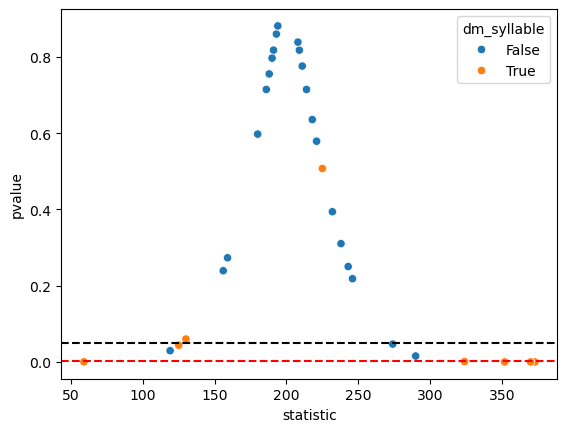

In [37]:
_filtered = separated_eigenvector_centralities[separated_eigenvector_centralities["source"].eq("original")]
_filtered = _filtered.set_index(["shuffled_repetition", "source", "context", "name", "dm_syllable", "syllable"])["eigenvector_centrality"].unstack("context")

mwu_df = _filtered.groupby(["dm_syllable", "syllable"]).apply(lambda x: mannwhitneyu(x["Dyadic"].dropna(), x["Solitary"].dropna())).apply(lambda x: pd.Series([x.statistic, x.pvalue], index=["statistic", "pvalue"]))
ax = sns.scatterplot(data=mwu_df, x="statistic", y="pvalue", hue="dm_syllable")
ax.axhline(0.05, color="k", linestyle="--")
ax.axhline(0.05 / len(mwu_df), color="r", linestyle="--")

In [38]:
save_object(separated_eigenvector_centralities, data_output_dir / "separated_eigenvector_centralities.pkl", overwrite=True)
save_object(mwu_df, data_output_dir / "eigenvector_mwu_df.pkl", overwrite=True)

## Panel C

In [39]:
full_separated_trans_series_copy = full_separated_trans_series.copy()
_idx_frame = full_separated_trans_series_copy.index.to_frame()
_idx_frame[["context", "name"]] = _idx_frame["context"].str.split(", ", expand=True)
_idx_frame = _idx_frame[["context", "name", "element0", "element1"]]
full_separated_trans_series_copy.index = pd.MultiIndex.from_frame(_idx_frame)
median_separated_trans_series = full_separated_trans_series_copy.groupby(["context", "element0", "element1"]).median()

median_separated_eigenvector_centralities = separated_eigenvector_centralities.groupby(["context", "syllable", "dm_syllable"])["eigenvector_centrality"].median()
mean_separated_eigenvector_centralities = separated_eigenvector_centralities.groupby(["context", "syllable", "dm_syllable"])["eigenvector_centrality"].mean()
median_separated_eigenvector_centralities

context   syllable  dm_syllable
Dyadic    0         False          0.358209
          1         False          0.207867
          2         False          0.200520
          3         False          0.160729
          4         False          0.149344
                                     ...   
Solitary  27        False          0.096083
          28        False          0.110099
          29        False          0.108289
          30        True           0.098978
          31        False          0.151560
Name: eigenvector_centrality, Length: 64, dtype: float64

In [40]:
delta_median_separated_trans_series = median_separated_trans_series.loc["Dyadic"] - median_separated_trans_series.loc["Solitary"]
delta_median_separated_eigenvector_centralities = median_separated_eigenvector_centralities.loc["Dyadic"] - median_separated_eigenvector_centralities.loc["Solitary"]
delta_mean_separated_eigenvector_centralities = mean_separated_eigenvector_centralities.loc["Dyadic"] - mean_separated_eigenvector_centralities.loc["Solitary"]

abs_delta_trans = delta_median_separated_trans_series.abs()

delta_median_eig_cent = delta_median_separated_eigenvector_centralities.reset_index("dm_syllable")
delta_mean_eig_cent = delta_mean_separated_eigenvector_centralities.reset_index("dm_syllable")
delta_median_eig_cent

,dm_syllable,eigenvector_centrality
syllable,,
0,False,0.010544
1,False,0.006186
2,False,-0.023204
3,False,0.004857
4,False,0.001849
5,True,-0.017873
6,False,-0.002984
7,True,-0.001070
8,False,-0.020017


In [41]:
name_syllables_dict = {track: track_syllables.droplevel("track") for track, track_syllables in moseq_df["syllable"].groupby("track")}

group_track_dict = moseq_df["context"].droplevel("frame_index")
group_track_dict = group_track_dict[~group_track_dict.index.duplicated(keep="first")].to_dict()

syllables_list = list(name_syllables_dict.values())
group_list = [group_track_dict[name] for name in name_syllables_dict.keys()]

In [42]:
n_repetitions = 1000
rng = np.random.default_rng(3429053)
n_jobs = os.cpu_count()

seeds = rng.integers(0, 2**32-1, n_repetitions)

def _shuffle_syllable_series(syllable_series, random_state=None):
    if random_state is None:
        random_state = np.random.default_rng()

    syllable_chunks = series_to_value_chunks(syllable_series)
    syllable_chunks["length"] = syllable_chunks["index_end"] - syllable_chunks["index_start"] + 1
    shuffled_chunks = syllable_chunks.sample(frac=1, random_state=random_state)

    shuffled_chunks["index_start"] = shuffled_chunks["length"].cumsum()
    shuffled_chunks["index_start"] = shuffled_chunks["index_start"].shift(1, fill_value=0)
    shuffled_chunks["index_end"] = shuffled_chunks["index_start"] + shuffled_chunks["length"] - 1

    shuffled_series = value_chunks_to_series(shuffled_chunks)
    shuffled_series.index.names = syllable_series.index.names
    return shuffled_series

def _calculate_shuffled_parameters(i, syllables_list, group_list, random_state=None):
    if random_state is None:
        random_state = np.random.default_rng()
    shuffled_syllables_list = [_shuffle_syllable_series(syllable_series, random_state=random_state) for syllable_series in syllables_list]
    _trans_series, _usages = get_group_syllable_transition_series(*shuffled_syllables_list, series_groups=group_list, normalize="rows")
    return i, _trans_series, _usages

with Parallel(n_jobs=os.cpu_count(), verbose=0) as parallel:
    results = parallel(delayed(_calculate_shuffled_parameters)(i, syllables_list, group_list, seeds[i]) for i in tqdm(range(n_repetitions)))

repetition_trans_series_dict = {i: v for i, v, _ in results}
repetition_usages_dict = {i: v for i, _, v in results}

100%|██████████| 1000/1000 [05:25<00:00,  3.07it/s]


In [43]:
repetition_trans_series_df = pd.concat({k: pd.concat(v, names=["context"], axis=0) for k,v in repetition_trans_series_dict.items()}, 
                                       names=["shuffled_repetition"], axis=0)
repetition_usages_df = pd.concat({k: pd.concat(v, names=["context"], axis=0) for k,v in repetition_usages_dict.items()},
                                    names=["shuffled_repetition"], axis=0)
transition_baseline_dict = {
    "trans_series": repetition_trans_series_df,
    "usages": repetition_usages_df,
    "seeds": {i: seeds[i] for i in range(n_repetitions)}
}

In [44]:
save_object(transition_baseline_dict, data_output_dir / "transition_baseline_dict.pkl", overwrite=True)

In [45]:
delta_baseline_trans_series = transition_baseline_dict["trans_series"].xs("Dyadic", level="context") - transition_baseline_dict["trans_series"].xs("Solitary", level="context")
delta_baseline_trans_thresholds = delta_baseline_trans_series.abs().groupby(["element0", "element1"]).quantile(0.99)  # the 99th percentile of the absolute bootstrap differences
delta_baseline_trans_thresholds

element0  element1
0         1           0.016810
          2           0.023435
          3           0.015936
          4           0.013962
          5           0.020775
                        ...   
98        49               NaN
          50               NaN
          53               NaN
          54               NaN
          62               NaN
Name: count, Length: 6170, dtype: float64

In [46]:
filtered_delta_trans = delta_median_separated_trans_series[delta_median_separated_trans_series.abs().ge(delta_baseline_trans_thresholds)]
filtered_delta_trans = filtered_delta_trans.sort_index().iloc[::-1]

for i in range(31, 0, -1):
    filtered_delta_trans.loc[i, i] = 0

filtered_delta_trans = filtered_delta_trans.iloc[::-1]

In [47]:
save_object(delta_median_eig_cent, data_output_dir / "delta_median_eig_cent.pkl", overwrite=True)
save_object(filtered_delta_trans, data_output_dir / "filtered_delta_trans.pkl", overwrite=True)

# Figure 3

## Panel A

In [48]:
# Is an image

## Panel B

In [49]:
interpolated_active_contact_series = pd.read_csv(data_output_dir / "InterpolatedActiveContactSeries.csv", index_col=[0, 1, 2, 3]).squeeze()
interpolated_passive_contact_series = pd.read_csv(data_output_dir / "InterpolatedPassiveContactSeries.csv", index_col=[0, 1, 2, 3]).squeeze()
randomized_contact_series = pd.read_csv(data_output_dir / "RandomizedContactSeries.csv", index_col=[0, 1, 2, 3]).squeeze()

In [50]:
span_before = int(5 * fps)
span_after = int(5 * fps)
relative_frame_index = list(range(-span_before, span_after+1))

def _get_trackwise_syllable_neighbourhoods(reindexed_moseq_df, contact_rle_df):
    contact_neighbour_syllable_df_list = []
    for track_id, track_df in reindexed_moseq_df.groupby("track_id"):
        track_neighbour_df = extract_neighbourhood_df(track_df.droplevel("track_id")["syllable"], contact_rle_df.index, span_before=span_before, span_after=span_after)
        track_neighbour_df = track_neighbour_df.dropna(how="any").astype(int)
        track_neighbour_df["track_id"] = track_id
        track_neighbour_df = track_neighbour_df.set_index("track_id", append=True)
        contact_neighbour_syllable_df_list.append(track_neighbour_df)
    return pd.concat(contact_neighbour_syllable_df_list).sort_index()

interpolated_active_contact_rle = rle_series(interpolated_active_contact_series, drop_run_values=[False])
interpolated_passive_contact_rle = rle_series(interpolated_passive_contact_series, drop_run_values=[False])
randomized_contact_rle = rle_series(randomized_contact_series, drop_run_values=[False])

active_contact_neighbour_syllable_df = _get_trackwise_syllable_neighbourhoods(dyadic_moseq_df_reindexed, interpolated_active_contact_rle)
passive_contact_neighbour_syllable_df = _get_trackwise_syllable_neighbourhoods(dyadic_moseq_df_reindexed, interpolated_passive_contact_rle)
randomized_contact_neighbour_syllable_df = _get_trackwise_syllable_neighbourhoods(dyadic_moseq_df_reindexed, randomized_contact_rle)

In [51]:
expected_distribution = dyadic_moseq_df_reindexed["syllable"].value_counts(normalize=True).loc[relevant_syllables]  # global frame proportions

active_frame_relative_observed_distribution = active_contact_neighbour_syllable_df.apply(lambda x: x.value_counts(normalize=True), axis=0).loc[relevant_syllables]
active_kl_div_series = active_frame_relative_observed_distribution.apply(lambda x: entropy(pk=x, qk=expected_distribution, base=2), axis=0)

passive_frame_relative_observed_distribution = passive_contact_neighbour_syllable_df.apply(lambda x: x.value_counts(normalize=True), axis=0).loc[relevant_syllables]
passive_kl_div_series = passive_frame_relative_observed_distribution.apply(lambda x: entropy(pk=x, qk=expected_distribution, base=2), axis=0)

randomized_frame_relative_observed_distribution = randomized_contact_neighbour_syllable_df.apply(lambda x: x.value_counts(normalize=True), axis=0).loc[relevant_syllables]
randomized_kl_div_series = randomized_frame_relative_observed_distribution.apply(lambda x: entropy(pk=x, qk=expected_distribution, base=2), axis=0)


In [52]:
track0_dyadic_syllables = dyadic_moseq_df_reindexed["syllable"].xs("0", level="track_id").rename("track0_syllables")
track1_dyadic_syllables = dyadic_moseq_df_reindexed["syllable"].xs("1", level="track_id").rename("track1_syllables")
combined_dyadic_syllables = pd.concat([track0_dyadic_syllables, track1_dyadic_syllables], axis=1)
combined_dyadic_array = combined_dyadic_syllables.values
combined_dyadic_array = np.apply_along_axis(lambda x: sorted(x), 1, combined_dyadic_array)
combined_dyadic_syllables = pd.DataFrame(combined_dyadic_array, index=combined_dyadic_syllables.index, columns=combined_dyadic_syllables.columns)
expected_across_distribution = combined_dyadic_syllables.value_counts(normalize=True)

_idx_frame = expected_across_distribution.index.to_frame()
_relevant_row_filter = _idx_frame.isin(relevant_syllables).all(axis=1)
expected_across_distribution = expected_across_distribution[_relevant_row_filter]

In [53]:
def _calculate_across_distribution(neighbourhood_df):
    neighbourhood_df = neighbourhood_df.stack("neighbourhood_index")
    track0_neighbourhood_df = neighbourhood_df.xs("0", level="track_id").rename("track0_syllables")
    track1_neighbourhood_df = neighbourhood_df.xs("1", level="track_id").rename("track1_syllables")
    combined_neighbourhood_df = pd.concat([track0_neighbourhood_df, track1_neighbourhood_df], axis=1)
    combined_neighbourhood_array = combined_neighbourhood_df.values
    combined_neighbourhood_array = np.apply_along_axis(lambda x: sorted(x), 1, combined_neighbourhood_array)
    combined_neighbourhood_df = pd.DataFrame(combined_neighbourhood_array, index=combined_neighbourhood_df.index, columns=combined_neighbourhood_df.columns)
    combined_neighbourhood_df = combined_neighbourhood_df.apply(lambda x: tuple(x), axis=1).unstack(level="neighbourhood_index")
    return combined_neighbourhood_df.apply(lambda x: x.value_counts(normalize=True), axis=0)

def _calculate_across_dkl(neighbourhood_df, expected_across_distribution):
    observed_across_distribution = _calculate_across_distribution(neighbourhood_df)
    return observed_across_distribution.apply(lambda x: entropy(pk=x.reindex(expected_across_distribution.index).fillna(0), qk=expected_across_distribution, base=2), axis=0)

across_active_kl_div_series = _calculate_across_dkl(active_contact_neighbour_syllable_df, expected_across_distribution)
across_passive_kl_div_series = _calculate_across_dkl(passive_contact_neighbour_syllable_df, expected_across_distribution)
across_randomized_kl_div_series = _calculate_across_dkl(randomized_contact_neighbour_syllable_df, expected_across_distribution)

In [54]:
def _joint_significance_test(baseline_series, eval_series_dict, baseline_slice=None):
    out_dict = {}

    if baseline_slice is None:
        baseline_slice = slice(-125, -50, 1)

    for label, eval_series in eval_series_dict.items():

        baseline_slice_series = eval_series.loc[baseline_slice]
        slice_eval_z_score = (eval_series - baseline_slice_series.mean()) / baseline_slice_series.std()
        slice_eval_significance = slice_eval_z_score.abs().ge(3)
        
        series_eval_z_score = (eval_series - baseline_series.mean()) / baseline_series.std()
        series_eval_significance = series_eval_z_score.abs().ge(3)

        joint_significance = slice_eval_significance & series_eval_significance
        out_dict[label] = joint_significance
    
    return out_dict


baseline_slice = slice(-125, -50, 1)

baseline_series = randomized_kl_div_series
eval_series_dict = {"Active": active_kl_div_series,
                    "Passive": passive_kl_div_series,
                    "Randomized": randomized_kl_div_series}

joint_significance_dict = _joint_significance_test(baseline_series, eval_series_dict, baseline_slice=baseline_slice)

across_baseline_series = across_randomized_kl_div_series
across_eval_series_dict = {"Active": across_active_kl_div_series,
                            "Passive": across_passive_kl_div_series,
                            "Randomized": across_randomized_kl_div_series}

across_joint_significance_dict = _joint_significance_test(across_baseline_series, across_eval_series_dict, baseline_slice=baseline_slice)

In [55]:
save_object(eval_series_dict, data_output_dir / "eval_series_dict.pkl", overwrite=True)
save_object(joint_significance_dict, data_output_dir / "joint_significance_dict.pkl", overwrite=True)
save_object(across_eval_series_dict, data_output_dir / "across_eval_series_dict.pkl", overwrite=True)
save_object(across_joint_significance_dict, data_output_dir / "across_joint_significance_dict.pkl", overwrite=True)

## Panel C

In [56]:
def slice_baseline_zscore(eval_series, baseline_slice=None):
    if baseline_slice is None:
        baseline_slice = slice(-125, -50, 1)
    baseline_slice_series = eval_series.loc[baseline_slice]
    slice_eval_z_score = (eval_series - baseline_slice_series.mean()) / baseline_slice_series.std()
    return slice_eval_z_score

joint_moseq_df_reindexed = moseq_df.reset_index()
joint_moseq_df_reindexed["strain"] = "Bl6"
joint_moseq_df_reindexed["light_cycle"] = joint_moseq_df_reindexed["light_cycle"].replace({"Normal": "norm", "Reverse": "reverse"})
joint_moseq_df_reindexed["mouse_id_string"] = joint_moseq_df_reindexed["track"].str.extract(r"(\d+(?:&\d+)?)")
joint_moseq_df_reindexed["track_id"] = joint_moseq_df_reindexed["track"].str.extract(r"_track(\d+)")

joint_moseq_df_reindexed = joint_moseq_df_reindexed.set_index(["strain", "light_cycle", "mouse_id_string", "track_id", "frame_index"])
joint_moseq_df_reindexed = joint_moseq_df_reindexed.sort_index()

In [57]:
_valid_track_id_slice = pd.IndexSlice[:, :, :, ["0", "1"], :]
syllable_series = joint_moseq_df_reindexed.loc[_valid_track_id_slice, "syllable"]
syllable_df = syllable_series.unstack("frame_index")
syllable_df

frame_index                                  756    757    758    759    \
strain light_cycle mouse_id_string track_id                               
Bl6    norm        1&4             0            17     17     17     17   
                                   1             8      8      8      8   
                   13&16           0            15     15     15     15   
                                   1             9      9      9      9   
                   19&22           0             7      7     15     15   
                                   1             4      4      4      4   
                   25&28           0            15     15      0      0   
                                   1             7      4      4      4   
                   7&10            0             4      4      4      4   
                                   1            20     20     20     20   
       reverse     1&4             0            10      9      9      9   
                                   1             0      0      0      5   
                   13&16           0            37     37     37     37   
                                   1             2      2      2      2   
                   19&22           0             0     31     31     31   
                                   1             2      2      2     28   
                   25&28           0            15     24     24     24   
                                   1             8      8      8      8   
                   7&10            0             2      2      2      2   
                                   1            45     45     45     45   

frame_index                                  760    761    762    763    \
strain light_cycle mouse_id_string track_id                               
Bl6    norm        1&4             0            17     17     17     17   
                                   1             8      8      8      8   
                   13&16           0            15     15     15     15   
                                   1             9      9      0      0   
                   19&22           0            15     15     15     15   
                                   1             9      9      9      9   
                   25&28           0             0     19     19     19   
                                   1             4      1      9      9   
                   7&10            0             4      4      4      4   
                                   1            20     16     16     16   
       reverse     1&4             0             9      9      9      0   
                                   1             5      5      5      5   
                   13&16           0            37     37     37     37   
                                   1             2      2      2      2   
                   19&22           0            31     31     31     31   
                                   1            28     28     28     28   
                   25&28           0            24     24     24     24   
                                   1             8      8      1      1   
                   7&10            0            22     12     12     12   
                                   1            45     45     45     45   

frame_index                                  764    765    ...  30267  30268  \
strain light_cycle mouse_id_string track_id                ...                 
Bl6    norm        1&4             0            17     17  ...     41     41   
                                   1            29     29  ...      1      1   
                   13&16           0            15     15  ...     19     19   
                                   1            25     25  ...      0      0   
                   19&22           0            15     15  ...     25     25   
                                   1             9      0  ...     31     31   
                   25&28           0            19     19 

In [58]:
global_match_df = get_pattern_match_df(syllable_df, hamming_distance=0, length=3)  # exact matches

100%|██████████| 41/41 [00:00<00:00, 13665.49it/s]


In [59]:
observed_frames = syllable_df.size  # total number of frames (frames per track x number of tracks)
global_match_df["length"] = global_match_df["sequence_index_end"] - global_match_df["sequence_index_start"] + 1
global_expected_frequencies = (global_match_df.groupby(["syllable_pattern", "syllable_match"])["length"].sum() / observed_frames).rename("global_frequency")

cumulative_cutoff = 0.95

# filter for consisting entirely of relevant syllables
_index_patterns = global_expected_frequencies.index.get_level_values("syllable_pattern")
relevant_syllable_filter = [all(syllable in relevant_syllables for syllable in pattern) for pattern in _index_patterns]
filtered_global_expected_frequencies = global_expected_frequencies[relevant_syllable_filter]

# filter for explaining 95% of the cumulative probability
global_expected_frequencies_cumulative = filtered_global_expected_frequencies.sort_values(ascending=False).cumsum()
global_expected_frequencies_cumulative = global_expected_frequencies_cumulative[global_expected_frequencies_cumulative.le(cumulative_cutoff)]

relevant_global_patterns = global_expected_frequencies_cumulative.droplevel("syllable_match").index
filtered_global_match_df = global_match_df[global_match_df["syllable_pattern"].isin(relevant_global_patterns)]

In [60]:
contact_neighbourhoods_dict = {
    "Active": active_contact_neighbour_syllable_df,
    "Passive": passive_contact_neighbour_syllable_df,
    "Randomized": randomized_contact_neighbour_syllable_df
}

fps = 25.25
span_before, span_after = int(5 * fps), int(5 * fps)

def _extract_neighbourhood_occurrence_frequency(syllable_pattern, contact_type):
    g_df = filtered_global_match_df[filtered_global_match_df["syllable_pattern"].apply(lambda x: x == syllable_pattern)]
    with pd.option_context("future.no_silent_downcasting", True):
        g_occ_series = match_df_to_occurrence_df(g_df).stack()
    
    contact_neighbourhood_df = contact_neighbourhoods_dict[contact_type].reorder_levels([0, 1, 2, 4, 3], axis=0)

    with pd.option_context("future.no_silent_downcasting", True):
        _neighbourhood_occurrence_df = extract_series_neighbourhood_df(g_occ_series, contact_neighbourhood_df.index, 
                                                                       span_before=span_before, span_after=span_after, 
                                                                       ignore_missing_multiindex_centers=True).fillna(False)
    return {(syllable_pattern, contact_type): (_neighbourhood_occurrence_df.sum(axis=0) / _neighbourhood_occurrence_df.count(axis=0)).rename_axis("relative_frame_index")}

args_list = [(syllable_pattern, contact_type) for syllable_pattern, _g_df in filtered_global_match_df.groupby("syllable_pattern") for contact_type in contact_neighbourhoods_dict.keys()]
filtered_args_list = [args for args in args_list if args[0] in relevant_global_patterns]

with Parallel(n_jobs=os.cpu_count()) as p:
    result_dict_list = p(delayed(_extract_neighbourhood_occurrence_frequency)(*args) for args in tqdm(filtered_args_list))

joint_result_dict = dict(ChainMap(*result_dict_list))
global_g_frequency_df = pd.concat(joint_result_dict, names=["syllable_pattern", "contact_type"]
                                  ).unstack("relative_frame_index", fill_value=0).astype(float)
global_g_frequency_df

100%|██████████| 312/312 [00:38<00:00,  8.20it/s]


relative_frame_index               -126      -125      -124      -123  \
syllable_pattern contact_type                                           
(0, 5, 1)        Active        0.010274  0.010274  0.010274  0.010274   
                 Passive       0.008639  0.008639  0.009719  0.008639   
                 Randomized    0.010251  0.010251  0.010251  0.010251   
(0, 5, 3)        Active        0.004566  0.004566  0.004566  0.004566   
                 Passive       0.009719  0.009719  0.010799  0.009719   
...                                 ...       ...       ...       ...   
(26, 9, 0)       Passive       0.009719  0.009719  0.010799  0.011879   
                 Randomized    0.004556  0.004556  0.004556  0.004556   
(31, 0, 5)       Active        0.006849  0.007991  0.007991  0.007991   
                 Passive       0.007559  0.008639  0.007559  0.007559   
                 Randomized    0.009112  0.010251  0.010251  0.010251   

relative_frame_index               -122      -121      -120      -119  \
syllable_pattern contact_type                                           
(0, 5, 1)        Active        0.010274  0.009132  0.009132  0.009132   
                 Passive       0.008639  0.008639  0.008639  0.008639   
                 Randomized    0.010251  0.011390  0.011390  0.010251   
(0, 5, 3)        Active        0.004566  0.004566  0.004566  0.005708   
                 Passive       0.009719  0.010799  0.010799  0.009719   
...                                 ...       ...       ...       ...   
(26, 9, 0)       Passive       0.010799  0.010799  0.010799  0.010799   
                 Randomized    0.004556  0.004556  0.004556  0.005695   
(31, 0, 5)       Active        0.007991  0.007991  0.010274  0.010274   
                 Passive       0.007559  0.007559  0.007559  0.007559   
                 Randomized    0.010251  0.010251  0.009112  0.007973   

relative_frame_index               -118      -117  ...       117       118  \
syllable_pattern contact_type                      ...                       
(0, 5, 1)        Active        0.009132  0.007991  ...  0.017123  0.017123   
                 Passive       0.008639  0.008639  ...  0.015119  0.016199   
                 Randomized    0.010251  0.011390  ...  0.014806  0.014806   
(0, 5, 3)        Active        0.005708  0.005708  ...  0.007991  0.007991   
                 Passive       0.009719  0.009719  ...  0.005400  0.005400   
...                                 ...       ...  ...       ...       ...   
(26, 9, 0)       Passive       0.010799  0.010799  ...  0.006479  0.006479   
                 Randomized    0.005695  0.005695  ...  0.005695  0.005695   
(31, 0, 5)       Active        0.011416  0.011416  ...  0.011416  0.011416   
                 Passive       0.005400  0.005400  ...  0.008639  0.007559   
                 Randomized    0.007973  0.007973  ...  0.009112  0.009112   

relative_frame_index                119       120       121       122  \
syllable_pattern contact_type                                           
(0, 5, 1)        Active        0.015982  0.014840  0.013699  0.013699   
                 Passive       0.016199  0.016199  0.016199  0.016199   
                 Randomized    0.014806  0.014806  0.014806  0.014806   
(0, 5, 3)        Active        0.007991  0.006849  0.006849  0.007991   
                 Passive       0.005400  0.004320  0.003240  0.003240   
...                                 ...       ...       ...       ...   
(26, 9, 0)       Passive       0.006479  0.006479  0.005400  0.005400   
                 Randomized    0.005695  0.004556  0.003417  0.003417   
(31, 0, 5)       Active        0.011416  0.011416  0.011416  0.011416   
                 Passive       0.007559  0.006479  0.006479  0.006479   
                 Randomized    0.007973  0.007973  0.007973  0.007973   

relative_frame_index                123       124       125       126  
syllable_pattern contact_type                                  

In [61]:
save_object(global_g_frequency_df, data_output_dir / "global_g_frequency_df.pkl", overwrite=True)

## Panel D

In [62]:
# only requires global_g_frequency_df

# Figure 4

## Panel A

In [63]:
# track centroids from Fig. 1C

track0_centroids_mm = track0_centroids / px_per_mm
track1_centroids_mm = track1_centroids / px_per_mm

rng = np.random.default_rng(232323)
n_points = 100000

dyadic_sampled_centroids = pd.concat([track0_centroids_mm.sample(n=n_points, random_state=rng), 
                                      track1_centroids_mm.sample(n=n_points, random_state=rng)], axis=0)

In [64]:
save_object(dyadic_sampled_centroids, data_output_dir / "dyadic_sampled_centroids.pkl", overwrite=True)

In [65]:
dyadic_centroid_df_mm = dyadic_centroid_df / px_per_mm

track0_centroids = dyadic_centroid_df_mm.loc[:, "0", :]
track1_centroids = dyadic_centroid_df_mm.loc[:, "1", :]

shuffled_track0_centroids = track0_centroids.sample(frac=1, random_state=rng).values
shuffled_track1_centroids = track1_centroids.sample(frac=1, random_state=rng).values

shuffled_point_distances = np.linalg.norm(shuffled_track0_centroids - shuffled_track1_centroids, axis=1)
shuffled_point_distances = pd.Series(shuffled_point_distances, name="mouse_distance")

observed_point_distances = centroid_distances.copy().reset_index(drop=True)
observed_point_distances.name = "mouse_distance"

In [66]:
arena_edge_length_mm = 453
n_random_point_pairs = 10000000
rng = np.random.default_rng(232323)

random_point_group1 = rng.uniform(0, arena_edge_length_mm, (n_random_point_pairs, 2))
random_point_group2 = rng.uniform(0, arena_edge_length_mm, (n_random_point_pairs, 2))
random_pair_distances = np.linalg.norm(random_point_group1 - random_point_group2, axis=1)

random_point_distances = pd.Series(random_pair_distances, name="mouse_distance")

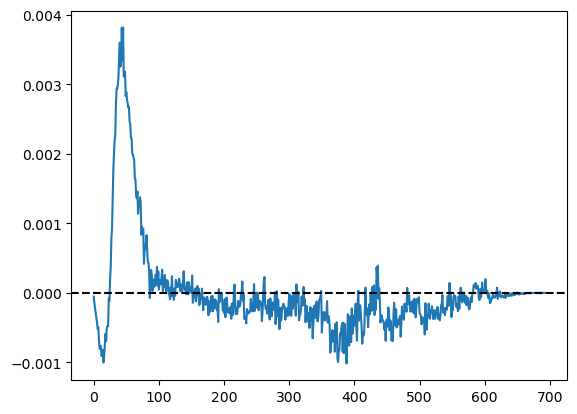

In [67]:
max_distance = np.max([shuffled_point_distances.max(), shuffled_point_distances.max()])
bins = np.linspace(0, int(max_distance), int(max_distance)+1)

observed_histogram = np.histogram(observed_point_distances, bins=bins, density=True)
shuffled_histogram = np.histogram(shuffled_point_distances, bins=bins, density=True)
random_histogram = np.histogram(random_point_distances, bins=bins, density=True)

pd.Series(observed_histogram[0] - shuffled_histogram[0], index=bins[:-1]).plot()
plt.axhline(0, color="black", linestyle="--")

In [68]:
distance_hist_df = pd.DataFrame({"Observed": observed_histogram[0], "Shuffled": shuffled_histogram[0], "Random": random_histogram[0]}, index=(bins[:-1] + bins[1:]) / 2)
distance_hist_df.index.name = "mouse_distance"
distance_hist_df.columns.name = "distance_type"

observed_shuffled_delta = distance_hist_df["Observed"] - distance_hist_df["Shuffled"]

distance_hist_series = distance_hist_df.stack().rename("density")
distance_hist_series

mouse_distance  distance_type
0.5             Observed         0.000000
                Shuffled         0.000054
                Random           0.000015
1.5             Observed         0.000020
                Shuffled         0.000169
                                   ...   
691.5           Shuffled         0.000000
                Random           0.000000
692.5           Observed         0.000000
                Shuffled         0.000000
                Random           0.000000
Name: density, Length: 2079, dtype: float64

In [69]:
save_object(distance_hist_series, data_output_dir / "distance_hist_series.pkl", overwrite=True)
save_object(observed_shuffled_delta, data_output_dir / "observed_shuffled_delta.pkl", overwrite=True)

## Panel B

In [70]:
match_df = get_pattern_match_df(syllable_df, patterns_to_match=[(9, 0, 5), (11, 2, 8)], hamming_distance=1)
occurrence_df = match_df_to_occurrence_df(match_df)
occurrence_df = occurrence_df.reindex_like(syllable_df).fillna(False).astype(bool)

_track0_occurrence_df, _track1_occurrence_df = occurrence_df.xs("0", level="track_id", axis=0), occurrence_df.xs("1", level="track_id", axis=0)
joint_occurrence_df = _track0_occurrence_df | _track1_occurrence_df

100%|██████████| 1/1 [00:00<?, ?it/s]
c:\Users\rittmart\OneDrive - Boehringer Ingelheim\jupyter_notebooks\2024_Manuscript\release\behavioral_analysis\pandas_tools\pattern_extraction.py:169: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  occurrence_df = occurrence_df.fillna(False).astype(bool)
C:\Users\rittmart\AppData\Local\Temp\ipykernel_82428\1761059268.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  occurrence_df = occurrence_df.reindex_like(syllable_df).fillna(False).astype(bool)


In [71]:
name_series = joint_moseq_df_reindexed["track"]
name_series = name_series.str.rsplit("_", n=1, expand=True)[0]
name_series.index = name_series.index.droplevel(["track_id", "frame_index"])
name_series = name_series[~name_series.index.duplicated(keep="first")]
name_reindex_df = name_series.index.to_frame()
name_reindex_df.index = name_series.values
name_reindex_df = name_reindex_df.rename_axis("recording_name", axis=0)
name_reindex_df

,strain,light_cycle,mouse_id_string
recording_name,,,
1 - 21-02-24.analysis,Bl6,norm,1
1&4 - 19-03-24.analysis,Bl6,norm,1&4
10 - 21-02-24.analysis,Bl6,norm,10
13 - 21-02-24.analysis,Bl6,norm,13
13&16 - 19-03-24.analysis,Bl6,norm,13&16
16 - 21-02-24.analysis,Bl6,norm,16
19 - 21-02-24.analysis,Bl6,norm,19
19&22 - 19-03-24.analysis,Bl6,norm,19&22
22 - 21-02-24.analysis,Bl6,norm,22


In [72]:
reindexed_centroid_distances = centroid_distances.rename("distance_mm").reset_index("frame_index").join(name_reindex_df).dropna(how="any").set_index(["strain", "light_cycle", "mouse_id_string", "frame_index"])["distance_mm"]
reindexed_centroid_distances

strain  light_cycle  mouse_id_string  frame_index
Bl6     norm         1&4              756            246.526371
                                      757            263.126421
                                      758            280.122502
                                      759            297.682716
                                      760            314.634674
                                                        ...    
        reverse      7&10             30272          388.517753
                                      30273          394.575263
                                      30274          400.459904
                                      30275          406.816418
                                      30276          409.278485
Name: distance_mm, Length: 295210, dtype: float64

In [73]:
window_width = 30

distance_df = reindexed_centroid_distances.unstack("frame_index")

distance_delta_df = distance_df.apply(lambda x: x.rolling(window_width).apply(lambda y: y.iloc[-1] - y.iloc[0]), axis=1)
pattern_prop_df = joint_occurrence_df.apply(lambda x: x.rolling(window_width).apply(lambda y: y.sum() / len(y)), axis=1)

rolling_df = distance_delta_df.stack().rename("delta_distance_mm").to_frame().join(pattern_prop_df.stack().rename("window_pattern_prop"))
rolling_df

delta_distance_mm  \
strain light_cycle mouse_id_string frame_index                      
Bl6    norm        1&4             785                 184.692243   
                                   786                 162.802149   
                                   787                 139.410247   
                                   788                 117.389609   
                                   789                  95.671760   
...                                                           ...   
       reverse     7&10            30272                71.441187   
                                   30273                74.589066   
                                   30274                78.574972   
                                   30275                83.284532   
                                   30276                85.201558   

                                                window_pattern_prop  
strain light_cycle mouse_id_string frame_index                       
Bl6    norm        1&4             785                     0.000000  
                                   786                     0.000000  
                                   787                     0.000000  
                                   788                     0.000000  
                                   789                     0.000000  
...                                                             ...  
       reverse     7&10            30272                   0.900000  
                                   30273                   0.933333  
                                   30274                   0.966667  
                                   30275                   1.000000  
                                   30276                   1.000000  

[294920 rows x 2 columns]

In [74]:
bin_cutoff, bin_width = 300, 10
delta_distance_bins = np.arange(-bin_cutoff, bin_cutoff+bin_width, bin_width)
rolling_df["delta_distance_bin"] = pd.cut(rolling_df["delta_distance_mm"], bins=delta_distance_bins, labels=[int(x + y) / 2 for x, y in zip(delta_distance_bins[:-1], delta_distance_bins[1:])])
rolling_df

delta_distance_mm  \
strain light_cycle mouse_id_string frame_index                      
Bl6    norm        1&4             785                 184.692243   
                                   786                 162.802149   
                                   787                 139.410247   
                                   788                 117.389609   
                                   789                  95.671760   
...                                                           ...   
       reverse     7&10            30272                71.441187   
                                   30273                74.589066   
                                   30274                78.574972   
                                   30275                83.284532   
                                   30276                85.201558   

                                                window_pattern_prop  \
strain light_cycle mouse_id_string frame_index                        
Bl6    norm        1&4             785                     0.000000   
                                   786                     0.000000   
                                   787                     0.000000   
                                   788                     0.000000   
                                   789                     0.000000   
...                                                             ...   
       reverse     7&10            30272                   0.900000   
                                   30273                   0.933333   
                                   30274                   0.966667   
                                   30275                   1.000000   
                                   30276                   1.000000   

                                               delta_distance_bin  
strain light_cycle mouse_id_string frame_index                     
Bl6    norm        1&4             785                      185.0  
                                   786                      165.0  
                                   787                      135.0  
                                   788                      115.0  
                                   789                       95.0  
...                                                           ...  
       reverse     7&10            30272                     75.0  
                                   30273                     75.0  
                                   30274                     75.0  
                                   30275                     85.0  
                                   30276                     85.0  

[294920 rows x 3 columns]

In [75]:
save_object(rolling_df, data_output_dir / "rolling_df.pkl", overwrite=True)

In [76]:
name_series = joint_moseq_df_reindexed["track"].drop_duplicates().droplevel("frame_index")

pattern_match_df_copy = match_df.copy()
pattern_match_df_copy = pattern_match_df_copy.join(name_series, on=["strain", "light_cycle", "mouse_id_string", "track_id"])
pattern_match_df_copy["recording_name"] = pattern_match_df_copy["track"].str.rsplit("_", n=1).str[0]
pattern_match_df_copy = pattern_match_df_copy.join(centroid_distances.rename("start_distance"), on=["recording_name", "sequence_index_start"])
pattern_match_df_copy = pattern_match_df_copy.join(centroid_distances.rename("end_distance"), on=["recording_name", "sequence_index_end"])
pattern_match_df_copy["distance_difference"] = pattern_match_df_copy["end_distance"] - pattern_match_df_copy["start_distance"]
pattern_match_df_copy

match  \
pattern strain light_cycle mouse_id_string track_id match_idx         
lci     Bl6    norm        1&4             0        0           lci   
                                                    1           lcw   
                                                    2           lci   
                                                    3           yci   
                                                    4           qci   
...                                                             ...   
jaf     Bl6    reverse     7&10            1        70          paf   
                                                    71          jaf   
                                                    72          paf   
                                                    73          ja   
                                                    74          xaf   

                                                              mismatches  \
pattern strain light_cycle mouse_id_string track_id match_idx              
lci     Bl6    norm        1&4             0        0                 []   
                                                    1                [2]   
                                                    2                 []   
                                                    3                [0]   
                                                    4                [0]   
...                                                                  ...   
jaf     Bl6    reverse     7&10            1        70               [0]   
                                                    71                []   
                                                    72               [0]   
                                                    73               [2]   
                                                    74               [0]   

                                                               match_start  \
pattern strain light_cycle mouse_id_string track_id match_idx                
lci     Bl6    norm        1&4             0        0                   13   
                                                    1                   35   
                                                    2                   38   
                                                    3                   74   
                                                    4                   99   
...                                                                    ...   
jaf     Bl6    reverse     7&10            1        70                1730   
                                                    71                1738   
                                                    72                1752   
                                                    73                1762   
                                                    74                1775   

                                                               match_end  \
pattern strain light_cycle mouse_id_string track_id match_idx              
lci     Bl6    norm        1&4             0        0                 16   
                                                    1                 38   
                                                    2                 41   
                                                    3                 77   
                                                    4                102   
...                                                                  ...   
jaf     Bl6    reverse     7&10            1        70              1733   
                                                    71              1741   
                                                    72              1755   
                                                    73              1765   
                                                    74              1778   

                                                              syllable_match  \
pattern strain light_cycle mouse_id_string track_id match_idx    

In [77]:
def bool_func_intersection(func_list):
    def inner(*args, **kwargs):
        return all([func(*args, **kwargs) for func in func_list])
    return inner

def bool_raster_from_functions(func_list, x_lim=None, y_lim=None, resolution=1):
    x_positions = np.arange(x_lim[0], x_lim[1]+resolution, resolution)
    y_positions = np.arange(y_lim[0], y_lim[1]+resolution, resolution)
    bool_raster = np.zeros((len(y_positions), len(x_positions)), dtype=bool)

    combined_bool_func = bool_func_intersection(func_list)

    for i, x in enumerate(x_positions):
        for j, y in enumerate(y_positions):
            bool_raster[j, i] = combined_bool_func(x, y)
    return bool_raster

def polygon_from_bool_functions(func_list, x_lim=None, y_lim=None, resolution=1):
    bool_raster = bool_raster_from_functions(func_list, x_lim=x_lim, y_lim=y_lim, resolution=resolution)
    
    raster_polygon = bool_raster_to_polygon(bool_raster)
    raster_polygon = translate(raster_polygon, xoff=x_lim[0]/resolution, yoff=y_lim[0]/resolution)
    raster_polygon = scale(raster_polygon, xfact=resolution, yfact=resolution, origin=(0, 0))
    return raster_polygon

In [78]:
resolution = 1
edge_length = 453
diagonal_length = np.sqrt(2) * edge_length
d_tol = contact_threshold  # distance tolerance (when does it count as "in contact"? in mm)
m_tol = contact_threshold / 2  # movement tolerance (relevant for detection of mobility. in mm)

starts_in_contact = lambda start_distance, distance_difference: start_distance <= d_tol
starts_just_out_of_contact = lambda start_distance, distance_difference: d_tol < start_distance <= 2*d_tol
starts_distant = lambda start_distance, distance_difference: 2*d_tol < start_distance <= diagonal_length
not_starts_in_contact = lambda start_distance, distance_difference: starts_just_out_of_contact(start_distance, distance_difference) or starts_distant(start_distance, distance_difference)

ends_in_contact = lambda start_distance, distance_difference: 0 <= (start_distance + distance_difference) <= d_tol
ends_just_out_of_contact = lambda start_distance, distance_difference: d_tol < (start_distance + distance_difference) <= 2*d_tol
ends_distant = lambda start_distance, distance_difference: 2*d_tol < (start_distance + distance_difference) <= diagonal_length
not_ends_in_contact = lambda start_distance, distance_difference: ends_just_out_of_contact(start_distance, distance_difference) or ends_distant(start_distance, distance_difference)

no_relative_movement = lambda start_distance, distance_difference: np.abs(distance_difference) <= m_tol
movement_away = lambda start_distance, distance_difference: distance_difference > m_tol
movement_towards = lambda start_distance, distance_difference: distance_difference < -m_tol

rastered_polygon_funcs = dict(
    contact=[starts_in_contact, ends_in_contact, no_relative_movement],
    targeted_leave=[starts_in_contact, not_ends_in_contact, movement_away],
    leave_control=[starts_just_out_of_contact, not_ends_in_contact, movement_away],
    targeted_approach=[not_starts_in_contact, ends_in_contact, movement_towards],
    approach_control=[not_starts_in_contact, ends_just_out_of_contact, movement_towards],
    stationary_no_contact=[starts_distant, ends_distant, no_relative_movement],
)

rastered_polygon_dict = {k: polygon_from_bool_functions(v, x_lim=(0, diagonal_length), y_lim=(-diagonal_length, diagonal_length), resolution=resolution) for k, v in rastered_polygon_funcs.items()}

In [79]:
reference_grid_resolution = 5

clean_polygon_dict = {}
for polygon_name, polygon in rastered_polygon_dict.items():
    clean_polygon = polygon.simplify(resolution)
    _coords = clean_polygon.exterior.coords
    _clean_coords = [(round_to_nearest_multiple(x, reference_grid_resolution), round_to_nearest_multiple(y, reference_grid_resolution)) for x, y in _coords]
    clean_polygon_dict[polygon_name] = Polygon(_clean_coords)
clean_polygon_dict["targeted_approach"].exterior.xy

(array('d', [640.0, 100.0, 100.0, 150.0, 640.0, 640.0]),
 array('d', [-640.0, -100.0, -50.0, -50.0, -540.0, -640.0]))

In [80]:
global_match_df_copy = global_match_df.copy()
global_match_df_copy = global_match_df_copy.join(name_series, on=["strain", "light_cycle", "mouse_id_string", "track_id"])

global_match_df_copy["recording_name"] = global_match_df_copy["track"].str.rsplit("_", n=1).str[0]
global_match_df_copy = global_match_df_copy.join(centroid_distances.rename("start_distance"), on=["recording_name", "sequence_index_start"])
global_match_df_copy = global_match_df_copy.join(centroid_distances.rename("end_distance"), on=["recording_name", "sequence_index_end"])
global_match_df_copy["distance_difference"] = global_match_df_copy["end_distance"] - global_match_df_copy["start_distance"]
global_match_df_copy

match  \
pattern strain light_cycle mouse_id_string track_id match_idx         
aa     Bl6    norm        1&4             0        0           aa   
                                                    1           aa   
                                                    2           aa   
                                                    3           aa   
                                           1        0           aa   
...                                                             ...   
j     Bl6    norm        1&4             1        0           j   
l}     Bl6    reverse     25&28           1        0           l}   
     Bl6    reverse     25&28           1        0              
     Bl6    norm        7&10            0        0              
d     Bl6    reverse     13&16           1        0           d   

                                                              mismatches  \
pattern strain light_cycle mouse_id_string track_id match_idx              
aa     Bl6    norm        1&4             0        0                 []   
                                                    1                 []   
                                                    2                 []   
                                                    3                 []   
                                           1        0                 []   
...                                                                  ...   
j     Bl6    norm        1&4             1        0                 []   
l}     Bl6    reverse     25&28           1        0                 []   
     Bl6    reverse     25&28           1        0                 []   
     Bl6    norm        7&10            0        0                 []   
d     Bl6    reverse     13&16           1        0                 []   

                                                               match_start  \
pattern strain light_cycle mouse_id_string track_id match_idx                
aa     Bl6    norm        1&4             0        0                  993   
                                                    1                 1120   
                                                    2                 1437   
                                                    3                 1801   
                                           1        0                  115   
...                                                                    ...   
j     Bl6    norm        1&4             1        0                 1663   
l}     Bl6    reverse     25&28           1        0                  367   
     Bl6    reverse     25&28           1        0                 1680   
     Bl6    norm        7&10            0        0                 1670   
d     Bl6    reverse     13&16           1        0                 1302   

                                                               match_end  \
pattern strain light_cycle mouse_id_string track_id match_idx              
aa     Bl6    norm        1&4             0        0                996   
                                                    1               1123   
                                                    2               1440   
                                                    3               1804   
                                           1        0                118   
...                                                                  ...   
j     Bl6    norm        1&4             1        0               1666   
l}     Bl6    reverse     25&28           1        0                370   
     Bl6    reverse     25&28           1        0               1683   
     Bl6    norm        7&10            0        0               1673   
d     Bl6    reverse     13&16           1        0               1305   

                                                              syllable_match  \
pattern strain light_cycle mouse_id_string track_id match_idx    

In [81]:
save_object(global_match_df_copy, data_output_dir / "global_match_df_copy.pkl", overwrite=True)
save_object(pattern_match_df_copy, data_output_dir / "pattern_match_df_copy.pkl", overwrite=True)
save_object(clean_polygon_dict, data_output_dir / "clean_polygon_dict.pkl", overwrite=True)

## Panel C

In [82]:
# nothing to add beyond panel b

## Panel D

In [83]:
global_match_df_copy_reindexed = global_match_df_copy.reset_index().set_index(["pattern", "track", "match_idx"])
_pattern_syll_lengths = global_match_df_copy_reindexed["syllable_lengths"].apply(pd.Series).rename_axis("pattern_index", axis=1).stack().rename("syll_length")
_pattern_sylls = global_match_df_copy_reindexed["syllable_match"].apply(pd.Series).rename_axis("pattern_index", axis=1).stack().rename("syllable")
_pattern_syll_length_df = _pattern_syll_lengths.to_frame().join(_pattern_sylls).pivot(columns="syllable", values="syll_length").fillna(0).astype(int)
_pattern_syll_length_df

syllable                                                          0   1   2   \
pattern track                            match_idx pattern_index               
acd     7&10 - 20-03-24.analysis_track0  0         0              10   0   0   
                                                   1               0   0   2   
                                                   2               0   0   0   
aci     1&4 - 19-03-24.analysis_track0   0         0              17   0   0   
                                                   1               0   0   5   
...                                                               ..  ..  ..   
½qc     19&22 - 20-03-24.analysis_track1 0         1               0   0   0   
                                                   2               0   0   2   
¿     1&4 - 20-03-24.analysis_track0   0         0               0   0   0   
                                                   1               0   0   0   
                                                   2               0   0   0   

syllable                                                          3   4   5   \
pattern track                            match_idx pattern_index               
acd     7&10 - 20-03-24.analysis_track0  0         0               0   0   0   
                                                   1               0   0   0   
                                                   2               4   0   0   
aci     1&4 - 19-03-24.analysis_track0   0         0               0   0   0   
                                                   1               0   0   0   
...                                                               ..  ..  ..   
½qc     19&22 - 20-03-24.analysis_track1 0         1               0   0   0   
                                                   2               0   0   0   
¿     1&4 - 20-03-24.analysis_track0   0         0               0   0   0   
                                                   1               0   0   0   
                                                   2               0   0   0   

syllable                                                          6   7   8   \
pattern track                            match_idx pattern_index               
acd     7&10 - 20-03-24.analysis_track0  0         0               0   0   0   
                                                   1               0   0   0   
                                                   2               0   0   0   
aci     1&4 - 19-03-24.analysis_track0   0         0               0   0   0   
                                                   1               0   0   0   
...                                                               ..  ..  ..   
½qc     19&22 - 20-03-24.analysis_track1 0         1               0   0   0   
                                                   2               0   0   0   
¿     1&4 - 20-03-24.analysis_track0   0         0               0   0   0   
                                                   1               0   0   0   
                                                   2               0   0   0   

syllable                                                          9   ...  71  \
pattern track                            match_idx pattern_index      ...       
acd     7&10 - 20-03-24.analysis_track0  0         0               0  ...   0   
                                                   1               0  ...   0   
                                                   2               0  ...   0   
aci     1&4 - 19-03-24.analysis_track0   0         0               0  ...   0   
                                                   1               0  ...   0   
...                                                               ..  ...  ..   
½qc     19&22 - 20-03-24.analysis_track1 0         1               0  ...   0   
                                                   2               0  ...   0   
¿     1&4 - 20-03-24.analysis_track0   0         0               

In [84]:
polygon_series = pd.Series(clean_polygon_dict)

pattern_match_polygon_check = global_match_df_copy_reindexed[["start_distance", "distance_difference"]].apply(
    lambda x: polygon_series.apply(
        lambda y: y.contains(Point(x["start_distance"], x["distance_difference"]))
        ), axis=1)

containing_polygon_series = pattern_match_polygon_check.rename_axis("containing_polygon", axis=1).stack().rename("contains_point")
containing_polygon_series = containing_polygon_series[containing_polygon_series].reset_index("containing_polygon").drop("contains_point", axis=1).squeeze()
global_match_df_copy_reindexed = global_match_df_copy_reindexed.join(containing_polygon_series)
global_match_df_copy_reindexed["only_relevant_sylls"] = global_match_df_copy_reindexed["syllable_match"].apply(lambda x: all(syllable in relevant_syllables for syllable in x))

filtered_global_match_df_copy_reindexed = global_match_df_copy_reindexed[global_match_df_copy_reindexed["only_relevant_sylls"]]
pattern_proportion_df = filtered_global_match_df_copy_reindexed.groupby("containing_polygon")["syllable_match"].value_counts(normalize=True).unstack().fillna(0)[relevant_global_patterns]

In [85]:
# get lowest significant decimal place for pattern_proportion_df
sign_decimal = np.log10(pattern_proportion_df).abs().replace(np.inf, np.nan).max(axis=None)
pattern_proportion_df += 0.1**(2*round(sign_decimal))

d:\BITrusted\conda_envs\manuscript2024\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


In [86]:
pattern_syll_length_df = _pattern_syll_length_df.groupby(_pattern_syll_length_df.index.names[:-1]).sum()
pattern_syll_total_df = pattern_syll_length_df.groupby(global_match_df_copy_reindexed["containing_polygon"]).sum()[relevant_syllables]
pattern_syll_total_df = (pattern_syll_total_df.T / pattern_syll_total_df.sum(axis=1)).T
pattern_syll_total_df

syllable,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
containing_polygon,,,,,,,,,,,,,,,,,,,,,
approach_control,0.089590,0.025116,0.042506,0.019094,0.021084,0.055148,0.044066,0.022410,0.073136,0.039267,...,0.029564,0.027327,0.026507,0.019523,0.013878,0.012473,0.027808,0.036783,0.020329,0.027249
contact,0.038668,0.061980,0.022186,0.042556,0.047633,0.026541,0.063273,0.045342,0.019529,0.040265,...,0.023627,0.034689,0.020137,0.015878,0.023056,0.023146,0.013434,0.006384,0.006494,0.005586
leave_control,0.056991,0.033622,0.030276,0.030416,0.021278,0.065850,0.062390,0.019960,0.075126,0.028755,...,0.034205,0.030568,0.019935,0.033749,0.011380,0.014866,0.016171,0.034965,0.017920,0.023027
stationary_no_contact,0.024523,0.049539,0.021410,0.047219,0.044100,0.021167,0.068886,0.048322,0.018502,0.032781,...,0.020112,0.019905,0.020615,0.014238,0.015600,0.018481,0.016963,0.008936,0.010294,0.004605
targeted_approach,0.083715,0.034588,0.038816,0.021576,0.023588,0.053607,0.043139,0.029633,0.073778,0.040468,...,0.031196,0.046183,0.019133,0.024392,0.013715,0.014272,0.019449,0.036620,0.012797,0.015905
targeted_leave,0.072832,0.031512,0.046586,0.027052,0.026677,0.057297,0.041787,0.013947,0.074234,0.038471,...,0.038163,0.031691,0.035628,0.024880,0.012532,0.016015,0.027563,0.020524,0.031297,0.014606


In [87]:
polygon_dkl_pair_dict = {}
for polygon1 in pattern_syll_total_df.index:
    for polygon2 in pattern_syll_total_df.index:
        if polygon1 != polygon2:
            polygon_dkl_pair_dict[(polygon1, polygon2)] = entropy(pattern_syll_total_df.loc[polygon1], qk=pattern_syll_total_df.loc[polygon2], base=2)

In [88]:
syntax_polygon_dkl_pair_dict = {}
for polygon1 in pattern_proportion_df.index:
    for polygon2 in pattern_proportion_df.index:
        if polygon1 != polygon2:
            syntax_polygon_dkl_pair_dict[(polygon1, polygon2)] = entropy(pattern_proportion_df.loc[polygon1], qk=pattern_proportion_df.loc[polygon2], base=2)

In [89]:
polygon_dkl_series = pd.Series(polygon_dkl_pair_dict)
polygon_dkl_series.index.names = ["polygon1", "polygon2"]
polygon_dkl_series.unstack("polygon2")

polygon2,approach_control,contact,leave_control,stationary_no_contact,targeted_approach,targeted_leave
polygon1,,,,,,
approach_control,NaN,0.343612,0.078000,0.431442,0.043967,0.052545
contact,0.295832,NaN,0.250161,0.056200,0.226963,0.266896
leave_control,0.080901,0.294069,NaN,0.364067,0.047381,0.064136
stationary_no_contact,0.379029,0.055558,0.308565,NaN,0.328552,0.378012
targeted_approach,0.044050,0.270296,0.048254,0.382654,NaN,0.051724
targeted_leave,0.050480,0.300214,0.066309,0.403289,0.052854,NaN


In [90]:
syntax_polygon_dkl_series = pd.Series(syntax_polygon_dkl_pair_dict)
syntax_polygon_dkl_series.index.names = ["polygon1", "polygon2"]
syntax_polygon_dkl_series.unstack("polygon2")

polygon2,approach_control,contact,leave_control,stationary_no_contact,targeted_approach,targeted_leave
polygon1,,,,,,
approach_control,NaN,0.495133,0.263745,0.613449,0.224591,0.223551
contact,1.187240,NaN,0.571326,0.100581,0.392471,0.528813
leave_control,0.738533,0.420840,NaN,0.509458,0.218510,0.249918
stationary_no_contact,1.336830,0.104766,0.624417,NaN,0.584730,0.766711
targeted_approach,0.484085,0.375293,0.188100,0.488387,NaN,0.157219
targeted_leave,0.439913,0.445940,0.186573,0.582277,0.144796,NaN


In [91]:
save_object(polygon_dkl_series, data_output_dir / "polygon_dkl_series.pkl", overwrite=True)
save_object(syntax_polygon_dkl_series, data_output_dir / "syntax_polygon_dkl_series.pkl", overwrite=True)

## Panel E

In [92]:
# nothing to add beyond d

# Figure 5

## Panel A

In [93]:
syll_frequencies_df = joint_moseq_df_reindexed.groupby(["context", "light_cycle", "mouse_id_string", "track_id"], dropna=False)["syllable"].value_counts(normalize=True).unstack().fillna(0)[relevant_syllables]
syll_frequencies_df = (syll_frequencies_df.T / syll_frequencies_df.sum(axis=1)).T
syll_frequencies_df.index = pd.MultiIndex.from_frame(syll_frequencies_df.index.to_frame().fillna(-1))
syll_frequencies_df

syllable                                             0         1         2   \
context  light_cycle mouse_id_string track_id                                 
Dyadic   norm        1&4             0         0.053185  0.035807  0.033517   
                                     1         0.049253  0.031409  0.022306   
                     13&16           0         0.066874  0.042624  0.037797   
                                     1         0.056126  0.038807  0.030811   
                     19&22           0         0.049555  0.039437  0.029177   
                                     1         0.053335  0.039322  0.025853   
                     25&28           0         0.036687  0.041515  0.029682   
                                     1         0.041392  0.059548  0.035630   
                     7&10            0         0.045355  0.039708  0.027556   
                                     1         0.032979  0.036487  0.020090   
         reverse     1&4             0         0.065074  0.030350  0.019944   
                                     1         0.036130  0.039303  0.037884   
                     13&16           0         0.026891  0.025841  0.033585   
                                     1         0.038416  0.055032  0.026002   
                     19&22           0         0.075497  0.057526  0.033363   
                                     1         0.026565  0.034155  0.042371   
                     25&28           0         0.100045  0.049762  0.021162   
                                     1         0.052769  0.060340  0.030598   
                     7&10            0         0.036442  0.043296  0.043406   
                                     1         0.033896  0.034408  0.024133   
Solitary norm        1               -1        0.044393  0.044314  0.025220   
                     10              -1        0.049796  0.041566  0.030604   
                     13              -1        0.042493  0.049660  0.039055   
                     16              -1        0.040546  0.033632  0.040620   
                     19              -1        0.044797  0.042403  0.031308   
                     22              -1        0.026356  0.031389  0.034302   
                     25              -1        0.037278  0.070380  0.026388   
                     28              -1        0.051762  0.051185  0.043358   
                     4               -1        0.041975  0.041093  0.031817   
                     7               -1        0.037313  0.057958  0.020247   
         reverse     1               -1        0.044861  0.042228  0.037034   
                     10              -1        0.025988  0.022807  0.035104   
                     13              -1        0.040852  0.034216  0.029471   
                     16              -1        0.056476  0.048352  0.029089   
                     19              -1        0.058808  0.066654  0.035347   
                     22              -1        0.029981  0.031515  0.039368   
                     25              -1        0.049651  0.048786  0.035568   
                     28              -1        0.039605  0.034916  0.042411   
                     4               -1        0.028509  0.029241  0.026569   
                     7               -1        0.049655  0.038687  0.041437   

syllable                                             3         4         5   \
context  light_cycle mouse_id_string track_id                                 
Dyadic   norm        1&4             0         0.035619  0.028450  0.037346   
                                     1         0.025904  0.026875  0.039539   
                     13&16           0         0.023314  0.041838  0.043971   
                                     1         0.023117  0.031606  0.051654   
                     19&22           0         0.041325  0.037300  0.038226   
                                     1         0.037222  0.036498  0.039467   
                     25&28           0         0.

In [94]:
save_object(syll_frequencies_df, data_output_dir / "syll_frequencies_df.pkl", overwrite=True)

## Panel B

In [95]:
global_syllable_df = joint_moseq_df_reindexed.set_index("context", append=True)["syllable"].unstack("frame_index")
global_syllable_df.index = pd.MultiIndex.from_frame(global_syllable_df.index.to_frame().fillna(-1)[["context", "strain", "light_cycle", "mouse_id_string", "track_id"]])
filtered_global_syllable_df = global_syllable_df[global_syllable_df.index.get_level_values("track_id") != -1]
filtered_global_syllable_df

frame_index                                          756    757    758    \
context strain light_cycle mouse_id_string track_id                        
Dyadic  Bl6    norm        1&4             0            17     17     17   
                                           1             8      8      8   
                           13&16           0            15     15     15   
                                           1             9      9      9   
                           19&22           0             7      7     15   
                                           1             4      4      4   
                           25&28           0            15     15      0   
                                           1             7      4      4   
                           7&10            0             4      4      4   
                                           1            20     20     20   
               reverse     1&4             0            10      9      9   
                                           1             0      0      0   
                           13&16           0            37     37     37   
                                           1             2      2      2   
                           19&22           0             0     31     31   
                                           1             2      2      2   
                           25&28           0            15     24     24   
                                           1             8      8      8   
                           7&10            0             2      2      2   
                                           1            45     45     45   

frame_index                                          759    760    761    \
context strain light_cycle mouse_id_string track_id                        
Dyadic  Bl6    norm        1&4             0            17     17     17   
                                           1             8      8      8   
                           13&16           0            15     15     15   
                                           1             9      9      9   
                           19&22           0            15     15     15   
                                           1             4      9      9   
                           25&28           0             0      0     19   
                                           1             4      4      1   
                           7&10            0             4      4      4   
                                           1            20     20     16   
               reverse     1&4             0             9      9      9   
                                           1             5      5      5   
                           13&16           0            37     37     37   
                                           1             2      2      2   
                           19&22           0            31     31     31   
                                           1            28     28     28   
                           25&28           0            24     24     24   
                                           1             8      8      8   
                           7&10            0             2     22     12   
                                           1            45     45     45   

frame_index                                          762    763    764    \
context strain light_cycle mouse_id_string track_id                        
Dyadic  Bl6    norm        1&4             0            17     17     17   
                                           1             8      8     29   
                           13&16           0            15     15     15   
                                           1             0      0     25   
                           19&22           0            15     15     15   
                                           1             9      9      9   
                           25&28           0  

In [96]:
observed_frames = syllable_df.size  # total number of frames (frames per track x number of tracks)
global_match_df["length"] = global_match_df["sequence_index_end"] - global_match_df["sequence_index_start"] + 1
global_expected_frequencies = (global_match_df.groupby(["syllable_pattern", "syllable_match"])["length"].sum() / observed_frames).rename("global_frequency")

cumulative_cutoff = 0.95

# filter for consisting entirely of relevant syllables
_index_patterns = global_expected_frequencies.index.get_level_values("syllable_pattern")
relevant_syllable_filter = [all(syllable in relevant_syllables for syllable in pattern) for pattern in _index_patterns]
filtered_global_expected_frequencies = global_expected_frequencies[relevant_syllable_filter]

# filter for explaining 95% of the cumulative probability
global_expected_frequencies_cumulative = filtered_global_expected_frequencies.sort_values(ascending=False).cumsum()
global_expected_frequencies_cumulative = global_expected_frequencies_cumulative[global_expected_frequencies_cumulative.le(cumulative_cutoff)]

print(filtered_global_expected_frequencies.sum())

relevant_global_patterns = global_expected_frequencies_cumulative.droplevel("syllable_match").index

2.60282680126012


In [97]:
target_length = 3
global_comparison_match_df = get_pattern_match_df(global_syllable_df, patterns_to_match=relevant_global_patterns, hamming_distance=0, length=target_length)  # exact matches
global_comparison_match_df

100%|██████████| 2/2 [00:00<?, ?it/s]


match  \
pattern context  strain light_cycle mouse_id_string track_id match_idx         
yx     Solitary Bl6    norm        1               -1       0           yx   
                                                             1           yx   
        Dyadic   Bl6    norm        1&4             0        0           yx   
                                                             1           yx   
                                                             2           yx   
...                                                                      ...   
zja     Dyadic   Bl6    reverse     7&10            0        0           zja   
                                                             1           zja   
                                                             2           zja   
                                                             3           zja   
                                                    1        0           zja   

                                                                       mismatches  \
pattern context  strain light_cycle mouse_id_string track_id match_idx              
yx     Solitary Bl6    norm        1               -1       0                 []   
                                                             1                 []   
        Dyadic   Bl6    norm        1&4             0        0                 []   
                                                             1                 []   
                                                             2                 []   
...                                                                           ...   
zja     Dyadic   Bl6    reverse     7&10            0        0                 []   
                                                             1                 []   
                                                             2                 []   
                                                             3                 []   
                                                    1        0                 []   

                                                                        match_start  \
pattern context  strain light_cycle mouse_id_string track_id match_idx                
yx     Solitary Bl6    norm        1               -1       0                 1289   
                                                             1                 1904   
        Dyadic   Bl6    norm        1&4             0        0                  172   
                                                             1                  308   
                                                             2                  575   
...                                                                             ...   
zja     Dyadic   Bl6    reverse     7&10            0        0                   42   
                                                             1                 1185   
                                                             2                 1712   
                                                             3                 2073   
                                                    1        0                  567   

                                                                        match_end  \
pattern context  strain light_cycle mouse_id_string track_id match_idx              
yx     Solitary Bl6    norm        1               -1       0               1292   
                                                             1               1907   
        Dyadic   Bl6    norm        1&4             0        0                175   
                                                             1                311   
                                                             2                578   
...                                                                           ...   
zja     Dyadic   Bl6    reverse     7&10            0        0                 45   
                           

In [98]:
global_comparison_match_df_copy = global_comparison_match_df.copy()

frames_per_track = len(syllable_df.columns)  # total number of frames (frames per track x number of tracks)

global_comparison_match_df_copy["length"] = global_comparison_match_df_copy["sequence_index_end"] - global_comparison_match_df_copy["sequence_index_start"] + 1
pattern_frequencies_df = (global_comparison_match_df_copy.groupby(["context", "light_cycle", "mouse_id_string", "track_id", "syllable_match"])["length"].sum() / frames_per_track).rename("global_frequency")
pattern_frequencies_df = pattern_frequencies_df.unstack().fillna(0)
pattern_frequencies_df

syllable_match                                 (0, 5, 1)  (0, 5, 3)  \
context  light_cycle mouse_id_string track_id                         
Dyadic   norm        1&4             0          0.013075   0.006368   
                                     1          0.008367   0.012567   
                     13&16           0          0.012330   0.006470   
                                     1          0.013075   0.009214   
                     19&22           0          0.011890   0.007723   
                                     1          0.007114   0.011687   
                     25&28           0          0.012601   0.006436   
                                     1          0.020358   0.006063   
                     7&10            0          0.006910   0.006504   
                                     1          0.004471   0.005826   
         reverse     1&4             0          0.006944   0.008028   
                                     1          0.006978   0.007249   
                     13&16           0          0.009315   0.010501   
                                     1          0.024728   0.006334   
                     19&22           0          0.017208   0.007791   
                                     1          0.006639   0.011991   
                     25&28           0          0.020629   0.013855   
                                     1          0.006030   0.001999   
                     7&10            0          0.002913   0.008638   
                                     1          0.004505   0.012771   
Solitary norm        1               -1         0.006843   0.025575   
                     10              -1         0.009993   0.009790   
                     13              -1         0.009214   0.005555   
                     16              -1         0.016293   0.008367   
                     19              -1         0.017005   0.011653   
                     22              -1         0.011483   0.011382   
                     25              -1         0.020325   0.014498   
                     28              -1         0.009214   0.010874   
                     4               -1         0.011720   0.009891   
                     7               -1         0.015379   0.011178   
         reverse     1               -1         0.011077   0.015785   
                     10              -1         0.009925   0.007994   
                     13              -1         0.025135   0.005962   
                     16              -1         0.028996   0.015311   
                     19              -1         0.011348   0.010670   
                     22              -1         0.008943   0.009857   
                     25              -1         0.016226   0.009756   
                     28              -1         0.005623   0.004573   
                     4               -1         0.008807   0.015718   
                     7               -1         0.005928   0.013584   

syllable_match                                 (0, 5, 9)  (0, 5, 10)  \
context  light_cycle mouse_id_string track_id                          
Dyadic   norm        1&4             0          0.004471    0.008469   
                                     1          0.008875    0.027065   
                     13&16           0          0.015921    0.034586   
                                     1          0.009383    0.040276   
                     19&22           0          0.007114    0.039328   
                                     1          0.007520    0.027574   
                     25&28           0          0.000948    0.005725   
                                     1          0.007927    0.008943   
                     7&10            0          0.012432    0.035432   
                                     1          0.002778    0.014024   
         reverse     1&4             0          0.013008    0.025236   
                                     1          0.004370    0.017242   
         

In [99]:
save_object(pattern_frequencies_df, data_output_dir / "pattern_frequencies_df.pkl", overwrite=True)

## Panel C

In [100]:
def _get_pca_df(input_df, n_components=4, return_explained_variance_ratios=False):
    X = input_df
    pipeline = make_pipeline(PCA(n_components=n_components))

    X_pca = pipeline.fit_transform(X)
    X_pca_df = pd.DataFrame(X_pca, index=X.index, columns=[f"PC{i}" for i in range(1, n_components+1)])

    variance_ratios = pipeline["pca"].explained_variance_ratio_

    return (X_pca_df, variance_ratios) if return_explained_variance_ratios else X_pca_df

syll_pca_df = _get_pca_df(syll_frequencies_df, n_components=3, return_explained_variance_ratios=False)
pattern_pca_df = _get_pca_df(pattern_frequencies_df, n_components=3, return_explained_variance_ratios=False)
pca_df = pd.concat({"syllable": syll_pca_df, "syntax": pattern_pca_df}, names=["feature"]).reset_index()

reindexed_pca_df = pca_df.set_index(["feature", "mouse_id_string", "track_id"])
context_disc_dict = {("context", g): g_df.drop(["context", "light_cycle"], axis=1) for g, g_df in reindexed_pca_df.groupby("context")}
light_cycle_disc_dict = {("light_cycle", g): g_df.drop(["context", "light_cycle"], axis=1) for g, g_df in reindexed_pca_df.groupby("light_cycle")}
disc_df = pd.concat({**context_disc_dict, **light_cycle_disc_dict}, names=["discriminant", "group"])
disc_df

PC1       PC2  \
discriminant group   feature  mouse_id_string track_id                       
context      Dyadic  syllable 1&4             0         0.013375 -0.037627   
                                              1         0.013547  0.029503   
                              13&16           0        -0.001438 -0.011381   
                                              1         0.059015  0.013114   
                              19&22           0         0.027283 -0.011782   
...                                                          ...       ...   
light_cycle  reverse syntax   22              -1        0.006717  0.030875   
                              25              -1        0.031990 -0.017342   
                              28              -1        0.013854  0.031071   
                              4               -1        0.001154  0.018977   
                              7               -1        0.032419  0.019937   

                                                             PC3  
discriminant group   feature  mouse_id_string track_id            
context      Dyadic  syllable 1&4             0        -0.035452  
                                              1         0.023723  
                              13&16           0         0.018508  
                                              1         0.035325  
                              19&22           0         0.015742  
...                                                          ...  
light_cycle  reverse syntax   22              -1       -0.004989  
                              25              -1       -0.029038  
                              28              -1       -0.043040  
                              4               -1        0.004421  
                              7               -1        0.003373  

[160 rows x 3 columns]

In [101]:
save_object(disc_df, data_output_dir / "disc_df.pkl", overwrite=True)